[Go to this directory index](./)

Contents
  - [Optimization method 2.5 parametric studies¶](#Optimization-method-2.5-parametric-studies)
    - [Setup¶](#Setup)
      - [Strategy¶](#Strategy)
    - [Parametric study across T_heat_reject¶](#Parametric-study-across-T_heat_reject)
      - [Step one¶](#Step-one)
      - [Postprocessing - Learning pandas and visualization¶](#Postprocessing---Learning-pandas-and-visualization)
      - [Step Two: Parameter sweep on output, optimize cost¶](#Step-Two:-Parameter-sweep-on-output,-optimize-cost)
  - [Scratch work¶](#Scratch-work)

# Optimization method 2.5 parametric studies

Previously, I obtained reasonable convergence on optima using a two-step strategy: first, simply enforce feasibility and optimize cooling output without regard to cost; then for any given cooling output goal less than the maximum, enforce that as a constraint and optimize system cost (from size and flow parameters). With some art in selecting constraint functions, I implemented this using the COBYLA optimization routine.

Since that method can be made to work, let's do a parametric study in two parameters: temperature for heat rejection (T) and cost (UA). For each heat reject temperature, we will determine the maximum cooling (Q_max), then build a cost vs cooling curve. The data should form a surface of points (T,UA,Q). We can also visualize that surface by projecting and plotting isolines, for example, isolines of UA on a (T,Q) plot.

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib
import numpy
from numpy import array, inf, nan
import pandas
from IPython.display import HTML, SVG, clear_output

In [4]:
#matplotlib.use('svg')
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'

In [5]:
from io import BytesIO
def pltsvg():
    imgdata = BytesIO()
    plt.savefig(imgdata)
    imgdata.seek(0)
    display(SVG(data=imgdata.read()))

In [6]:
import ammonia1
import system_aqua1
import scipy.optimize

In [7]:
def saturate(x, bottom=-numpy.inf, top=0):
    a_bottom = numpy.empty_like(x)
    a_top = numpy.empty_like(x)
    a_bottom.fill(bottom)
    a_top.fill(top)
    return numpy.minimum(a_top,
                         numpy.maximum(a_bottom,
                                       x))

def barrier1(c, length_scale):
    """The domain for B is the feasible set only.
    We want B large near boundary, but small elsewhere.
    Feasible means c > 0 and g < 0. Please input c.
    """
    g = numpy.negative(c)
    b = numpy.exp(g / length_scale)
    return numpy.sum(b)

def decay1(step_number, initial_value = 1., rate = 1.):
    """A decaying function to scale barrier functions.
    step_number: as this increases, I decay.
    initial_value: value when step_number = 0.
    decay_rate: how fast to decay.
    """
    # Magnitude tends to zero, slowly
    mu_B = initial_value * numpy.exp(-rate * step_number)
    return mu_B        

def penalty1(c, length_scale):
    """We want P = 0 for feasible, P > 0 elsewhere
    Feasible means c > 0 and g < 0.
    """
    g = numpy.negative(c)
    g = saturate(g,bottom=0,top=numpy.inf)
    p = (g / length_scale)**2
    return numpy.sum(p)

def grow1(step_number, initial_value = 1., rate = 1.):
    """A growing function to scale penalty functions."""
    # Magnitude tends to infinite, bit more quickly
    mu_P = initial_value * numpy.exp(rate * step_number)
    return mu_P


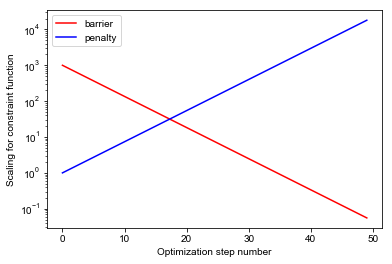

In [16]:
step_number = numpy.arange(50)
mu_B = decay1(step_number,initial_value=1000,rate=0.2)
mu_P = grow1(step_number,initial_value=1,rate=0.2)
plt.close('all')
plt.figure()
plt.semilogy(step_number,mu_B,'r',label='barrier')
plt.semilogy(step_number,mu_P,'b',label='penalty')
plt.xlabel('Optimization step number')
plt.ylabel('Scaling for constraint function')
plt.legend()
plt.show()

### Strategy
An extension of a previous idea, kind of the dual problem -- Perform optimization in two steps: first with no constraint on UA (cost) to determine maximum Q (output). Then for each Q in a set of lesser values, optimize with respect to cost. This will deliver an optimal cost vs output curve.

For the first step, since we are not interested in UA, we can be less strict with the constraints on heat exchange feasibility. Specifically, we can impose them via penalty constraints instead of barrier constraints.

In [8]:
class Problem_2_5_A:
    def __init__(self, bdry, mu=0.1):
        self.bdry = bdry
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        # print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T]                        
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [deltaT - 0.01
                         for name, deltaT, epsilon, UA, Qhx in sys.data]
            P = mu_P * penalty1(penalties,1)
            
            Q = sys.chiller.Q_evap
        except KeyboardInterrupt as e:
            raise e
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [9]:
class Problem_2_5_B:
    def __init__(self, bdry, Q_goal, mu=0.1):
        self.bdry = bdry
        self.Q_goal = Q_goal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective_raw(self, xC):
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            UA = sys.totalUA
        except:
            UA = numpy.nan
        return UA

        
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        #print(xC,flush=True)
        UA,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 1000. * numpy.exp(-0.1 * step_number)
            length_scale_b = 1
            # Or ... magnitude fixed, but shape changes
            mu_B = 1000
            length_scale_b = 1 * numpy.exp(-0.1 * step_number)
            
            # These are zero at the boundary ...
            barriers = [ch.check_rectifier_delta_T] \
                       + [deltaT
                          for name, deltaT, epsilon, UA, Qhx in sys.data]
            B = mu_B * barrier1(barriers,length_scale_b)
            
            # Penalties
            # Magnitude tends to infinite
            mu_P = 1 * numpy.exp(0.3 * step_number)
            penalties = [ch.Q_evap - self.Q_goal]
            P = mu_P * penalty1(penalties,1)
            
            UA = sys.totalUA
        except KeyboardInterrupt as e:
            raise e
        except:
            UA = numpy.inf
        
        # print(self.n_calls, step_number, UA, B, P, "\n", flush=True)
        return UA + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 0.1,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

## Parametric study across T_heat_reject

In [10]:
def display_result(x):
    try:
        print("X = ")
        display(x)
        ch = system_aqua1.makeChiller(x)
        sys = system_aqua1.System(bdry, ch)
        display(sys)
    except KeyboardInterrupt as e:
        raise e
    except Exception as e:
        display(e)

In [11]:
t_heat_reject_range = 273.15 + numpy.arange(20,61,5)

In [147]:
opts = [None] * len(t_heat_reject_range)

### Step one

In [24]:
for i,T_heat_reject in enumerate(t_heat_reject_range):
    if opts[i] is None:
        print("Case {}, T_heat_reject = {} K".format(i, T_heat_reject))
        rT = T_heat_reject
        xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_A(bdry)
        x = numpy.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])
        
        P.n_calls = 7*30
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("First pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*40
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("Second pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*50
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.01})
        display("Third pass and we have this ... ")
        display_result(x)

        opts[i] = opt

Case 0, T_heat_reject = 293.15 K


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


211 30.0 29.3426607866 8.88824099481e-197 2045.94701491 

Note: Absorber inlet is subcooled
212 30.0 88.0279823597 8.88824099481e-197 2045.95661909 

Note: Absorber inlet is subcooled
213 30.0 88.2479969814 9.83458747162e-196 1914.60615648 

Note: Absorber inlet is subcooled
214 30.0 88.1631796043 1.01618763273e-196 1822.45823884 

Note: Absorber inlet is subcooled
215 30.0 88.1631796043 7.57316972933e-196 1822.45823884 

Note: Absorber inlet is subcooled
216 30.0 87.9564109646 1.14805121731e-197 1280.0294175 

Note: Absorber inlet is subcooled
217 30.0 88.005971887 1.14805121731e-197 1299.88010459 

Note: Absorber inlet is subcooled
218 31.0 93.8320709629 1.33399233081e-219 1108.62680934 

Note: Absorber inlet is subcooled
219 31.0 98.1737330263 6.74568544905e-221 997.074130878 

Note: Absorber inlet is subcooled
220 31.0 100.308567159 9.12443222761e-220 958.766363235 

Note: Absorber inlet is subcooled
221 31.0 71.4845744468 9.15266871564e-220 933.779022092 

Note: Absorber inlet is 

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89591,0.953251,8.95054,180.194
rect,6.16349,0.77556,1.02236,9.72029
abs,-0.000194433,1.00002,inf,175.826
cond,1.54541,0.970924,35.4646,123.273
evap,0.0363772,0.995287,89.6341,128.423
total,0,0,inf,0


Note: Absorber inlet is subcooled
281 40.0 128.423482186 0.0 16.914530482 

Note: Absorber inlet is subcooled
282 40.0 186.545908554 0.0 2178629.81334 

Note: Absorber inlet is subcooled
283 40.0 128.744907878 0.0 1390.18056358 

Note: Absorber inlet is subcooled
284 40.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 127.996758765 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 128.37139887 0.0 0.208133304003 

Note: Absorber inlet is subcooled
288 41.0 70.232060958 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 129.379905687 0.0 6.87637500976 

Note: Absorber inlet is subcooled
290 41.0 155.463107725 0.0 565360.303557 

Note: Absorber inlet is subcooled
291 41.0 113.791554212 0.0 0.0 

Note: Absorber inlet is subcooled
292 41.0 128.297627118 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 128.335723806 0.0 0.241722009911 

Note: Absorber inlet is subcooled
294 41.0 128.335240285 0.0

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89387,0.953227,9.0128,180.745
rect,5.50136,0.809975,1.19735,10.2417
abs,0.0117575,0.999228,396.56,176.371
cond,1.62968,0.970423,34.215,123.112
evap,0.0158304,0.997949,103.544,128.777
total,0,0,544.529,0


Note: Absorber inlet is subcooled
351 50.0 128.776871008 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 134.583452607 0.0 381321.209955 

Note: Absorber inlet is subcooled
353 50.0 128.809115981 0.0 119.858891256 

Note: Absorber inlet is subcooled
354 50.0 128.764231518 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 128.776871008 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 128.746632988 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 128.784280347 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 122.977355274 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 128.909616822 0.0 0.0 

Note: Absorber inlet is subcooled
360 51.0 128.917186587 0.0 7.15431674744 

Note: Absorber inlet is subcooled
361 51.0 129.472643992 0.0 4192.80069994 

Note: Absorber inlet is subcooled
362 51.0 128.912784123 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 128.929891676 0.0 54.5211387278 

Note: Absorber inlet is subcooled
364 51.0 128.912784123 0.0 0.0 

Note: Absorb

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.89387,0.953227,9.0128,180.745
rect,5.50136,0.809975,1.19735,10.2417
abs,0.0117575,0.999228,396.56,176.371
cond,1.62968,0.970423,34.215,123.112
evap,0.0158304,0.997949,103.544,128.777
total,0,0,544.529,0


Case 1, T_heat_reject = 298.15 K
Note: Absorber inlet is subcooled
211 30.0 24.5883547239 1.01305231855e-250 3156.278929 

Note: Absorber inlet is subcooled
212 30.0 73.7650641718 1.01305231855e-250 3156.2910157 

Note: Absorber inlet is subcooled
213 30.0 73.9673270767 1.20595045745e-249 3144.35934709 

Note: Absorber inlet is subcooled
214 30.0 73.8724667435 1.18138325969e-250 2961.13902246 

Note: Absorber inlet is subcooled
215 30.0 73.8724667435 8.80429524319e-250 2961.13902246 

Note: Absorber inlet is subcooled
216 30.0 73.6861850466 1.29308121156e-251 2157.21304698 

Note: Absorber inlet is subcooled
217 30.0 73.7452878644 1.29308121156e-251 2208.13157745 

Note: Absorber inlet is subcooled
218 31.0 76.3946869366 1.40969493378e-279 1978.41316719 

Note: Absorber inlet is subcooled
219 31.0 78.0998625965 5.41819018621e-281 1878.72104919 

Note: Absorber inlet is subcooled
220 31.0 102.263696544 7.24475114495e-281 1902.88874034 

Note: Absorber inlet is subcooled
221 31.0 71.3959

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.72568,0.942974,13.5578,188.286
rect,6.32268,0.798931,1.25848,12.9269
abs,0.0658155,0.996278,151.077,181.903
cond,1.72475,0.968174,33.1259,121.225
evap,0.00852878,0.998883,113.698,127.462
total,0,0,312.717,0


Note: Absorber inlet is subcooled
281 40.0 127.461974329 0.0 0.352282771288 

Note: Absorber inlet is subcooled
282 40.0 176.053323473 0.0 1411320.49389 

Note: Absorber inlet is subcooled
283 40.0 127.812999795 0.0 2424.28720848 

Note: Absorber inlet is subcooled
284 40.0 127.295013964 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 127.295013964 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 126.972873178 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 127.399272088 0.0 0.0 

Note: Absorber inlet is subcooled
288 41.0 78.8315253996 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 127.751533304 0.0 0.0 

Note: Absorber inlet is subcooled
290 41.0 127.832396933 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 152.099213946 0.0 446705.172014 

Note: Absorber inlet is subcooled
292 41.0 127.744197618 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 103.56980027 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 127.832396933 0.0 0.0 

Note: Absorber inlet i

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.59327,0.944479,13.8375,189.054
rect,5.69765,0.824097,1.42883,13.4535
abs,0.0532557,0.996993,162.557,182.646
cond,1.80619,0.967714,32.0739,121.142
evap,0.0295339,0.996154,93.0342,127.878
total,0,0,302.931,0


Note: Absorber inlet is subcooled
351 50.0 127.877756489 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 132.73287088 0.0 239926.242178 

Note: Absorber inlet is subcooled
353 50.0 127.912957378 0.0 0.0 

Note: Absorber inlet is subcooled
354 50.0 127.896200962 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 127.912957378 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 127.880609233 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 127.923414695 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 123.066566817 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 130.351981593 0.0 84614.5291692 

Note: Absorber inlet is subcooled
360 51.0 127.923414514 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 125.494929393 0.0 0.0 

Note: Absorber inlet is subcooled
362 51.0 127.927603211 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 130.356249609 0.0 84926.8477442 

Note: Absorber inlet is subcooled
364 51.0 127.927603211 0.0 0.0 

Note: Absorber inlet is subcooled

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.59327,0.944479,13.8375,189.054
rect,5.69765,0.824097,1.42883,13.4535
abs,0.0532557,0.996993,162.557,182.646
cond,1.80619,0.967714,32.0739,121.142
evap,0.0295339,0.996154,93.0342,127.878
total,0,0,302.931,0


Case 2, T_heat_reject = 303.15 K
Note: Absorber inlet is subcooled
211 30.0 19.9331400856 1.55372380346e-306 0.0 

Note: Absorber inlet is subcooled
212 30.0 59.7994202567 1.55372380346e-306 0.0 

Note: Absorber inlet is subcooled
213 30.0 59.99131292 1.98845108119e-305 0.0 

Note: Absorber inlet is subcooled
214 30.0 59.8837069901 1.82759732759e-306 0.0 

Note: Absorber inlet is subcooled
215 30.0 59.99131292 1.48189931183e-304 0.0 

Note: Absorber inlet is subcooled
216 30.0 59.8182702399 2.1117748481e-306 0.0 

Note: Absorber inlet is subcooled
217 30.0 60.0605796362 1.98845108119e-305 0.0 

Note: Absorber inlet is subcooled
218 31.0 100.103386032 0.0 0.0 

Note: Absorber inlet is subcooled
219 31.0 140.148954111 0.0 3382.59617044 

Note: Absorber inlet is subcooled
220 31.0 86.0536995635 0.0 0.0 

Note: Absorber inlet is subcooled
221 31.0 100.13550747 0.0 0.0 

Note: Absorber inlet is subcooled
222 31.0 94.8860201301 0.0 0.0 

Note: Absorber inlet is subcooled
223 31.0 100.1272660

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.7376,0.928577,27.6219,203.176
rect,7.8445,0.770793,1.24269,15.7568
abs,0.249032,0.987074,99.8262,194.275
cond,1.393,0.968503,38.0245,124.056
evap,0.0103254,0.998679,110.891,130.441
total,0,0,277.606,0


Note: Absorber inlet is subcooled
281 40.0 130.441454491 0.0 0.0 

Note: Absorber inlet is subcooled
282 40.0 170.52307329 0.0 17485258.3814 

Note: Absorber inlet is subcooled
283 40.0 130.858162717 0.0 2509.1821583 

Note: Absorber inlet is subcooled
284 40.0 130.208348306 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 130.441454491 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 130.066125676 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 130.591384769 0.0 12.1603681215 

Note: Absorber inlet is subcooled
288 41.0 90.3597946504 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 110.400619974 0.0 0.0 

Note: Absorber inlet is subcooled
290 41.0 130.498596166 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 130.480055926 0.0 0.0 

Note: Absorber inlet is subcooled
292 41.0 140.512398717 0.0 73275.3669528 

Note: Absorber inlet is subcooled
293 41.0 130.498703194 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 120.482074698 0.0 0.0 

Note: Absorber inlet is 

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.73849,0.92856,28.0021,203.826
rect,7.85109,0.770432,1.24671,15.7945
abs,0.232539,0.987928,103.252,194.893
cond,1.36067,0.968558,38.5732,124.453
evap,0.0111087,0.998583,109.721,130.844
total,0,0,280.795,0


Note: Absorber inlet is subcooled
351 50.0 130.844130436 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 134.851967143 0.0 186185.771331 

Note: Absorber inlet is subcooled
353 50.0 130.885901065 0.0 420.805617671 

Note: Absorber inlet is subcooled
354 50.0 130.821146007 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 130.844130436 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 130.80645533 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 130.859181492 0.0 0.0 

Note: Absorber inlet is subcooled
358 51.0 126.850802513 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 130.861919943 0.0 0.0 

Note: Absorber inlet is subcooled
360 51.0 130.871341085 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 132.875566427 0.0 58858.8734849 

Note: Absorber inlet is subcooled
362 51.0 130.871341498 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 128.867145045 0.0 0.0 

Note: Absorber inlet is subcooled
364 51.0 130.871341498 0.0 0.0 

Note: Absorber inlet is subcooled

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,4.73849,0.92856,28.0021,203.826
rect,7.85109,0.770432,1.24671,15.7945
abs,0.232539,0.987928,103.252,194.893
cond,1.36067,0.968558,38.5732,124.453
evap,0.0111087,0.998583,109.721,130.844
total,0,0,280.795,0


Case 3, T_heat_reject = 308.15 K
Note: Absorber inlet is subcooled
211 30.0 15.2618651202 0.0 0.0 

Note: Absorber inlet is subcooled
212 30.0 45.7855953606 0.0 0.0 

Note: Absorber inlet is subcooled
213 30.0 45.9716522196 0.0 0.0 

Note: Absorber inlet is subcooled
214 30.0 45.8534097791 0.0 0.0 

Note: Absorber inlet is subcooled
215 30.0 45.9716522196 0.0 0.0 

Note: Absorber inlet is subcooled
216 30.0 45.8072772852 0.0 0.0 

Note: Absorber inlet is subcooled
217 30.0 46.0525326126 0.0 0.0 

Note: Absorber inlet is subcooled
218 31.0 76.7573512575 0.0 0.0 

Note: Absorber inlet is subcooled
219 31.0 107.465735928 0.0 0.0 

Note: Absorber inlet is subcooled
220 31.0 138.177666994 0.0 1463186.64115 

Note: Absorber inlet is subcooled
221 31.0 107.58959751 0.0 0.0 

Note: Absorber inlet is subcooled
222 31.0 93.9176322107 0.0 0.0 

Note: Absorber inlet is subcooled
223 31.0 107.698969248 0.0 0.0 

Note: Absorber inlet is subcooled
224 31.0 99.4908168 0.0 0.0 

Note: Absorber inlet is

'First pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.0453529,0.998956,124.808,181.433
rect,7.93188,0.8057,1.15552,17.1645
abs,2.26958,0.891645,29.7156,171.221
cond,2.40825,0.969135,24.6252,102.215
evap,1.29735,0.983616,30.0293,108.549
total,0,0,210.333,0


Note: Absorber inlet is subcooled
281 40.0 108.548861742 0.0 0.0 

Note: Absorber inlet is subcooled
282 40.0 139.371601696 0.0 22928228.5407 

Note: Absorber inlet is subcooled
283 40.0 108.986261483 0.0 0.0 

Note: Absorber inlet is subcooled
284 40.0 108.709576827 0.0 0.0 

Note: Absorber inlet is subcooled
285 40.0 108.986261483 0.0 0.0 

Note: Absorber inlet is subcooled
286 40.0 108.599580147 0.0 0.0 

Note: Absorber inlet is subcooled
287 40.0 109.175241593 0.0 403.759633968 

Note: Absorber inlet is subcooled
288 41.0 78.0393183353 0.0 0.0 

Note: Absorber inlet is subcooled
289 41.0 110.074768591 0.0 32146.4013095 

Note: Absorber inlet is subcooled
290 41.0 109.037117157 0.0 0.0 

Note: Absorber inlet is subcooled
291 41.0 112.907151088 0.0 479888.156385 

Note: Absorber inlet is subcooled
292 41.0 101.297046998 0.0 0.0 

Note: Absorber inlet is subcooled
293 41.0 109.091815409 0.0 0.0 

Note: Absorber inlet is subcooled
294 41.0 116.837878554 0.0 1935380.98419 

Note: Absorb

'Second pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.01694,0.999611,181.239,182.083
rect,7.9359,0.804712,1.16013,17.1639
abs,2.22358,0.89363,30.2169,171.88
cond,2.3679,0.969199,24.9814,102.787
evap,1.15053,0.983837,31.798,109.131
total,0,0,269.395,0


Note: Absorber inlet is subcooled
351 50.0 109.130679142 0.0 0.0 

Note: Absorber inlet is subcooled
352 50.0 112.22899717 0.0 4581228.20733 

Note: Absorber inlet is subcooled
353 50.0 109.174442408 0.0 0.0 

Note: Absorber inlet is subcooled
354 50.0 109.14680683 0.0 0.0 

Note: Absorber inlet is subcooled
355 50.0 109.174442408 0.0 0.0 

Note: Absorber inlet is subcooled
356 50.0 109.135742354 0.0 0.0 

Note: Absorber inlet is subcooled
357 50.0 109.193339548 0.0 8.05277994397 

Note: Absorber inlet is subcooled
358 51.0 106.074881871 0.0 0.0 

Note: Absorber inlet is subcooled
359 51.0 109.723655898 0.0 183581.247215 

Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


360 51.0 108.399552246 0.0 0.0 

Note: Absorber inlet is subcooled
361 51.0 109.179925909 0.0 0.0 

Note: Absorber inlet is subcooled
362 51.0 109.184590739 0.0 0.0 

Note: Absorber inlet is subcooled
363 51.0 109.18942866 0.0 0.0 

Note: Absorber inlet is subcooled
364 51.0 109.964610554 0.0 379523.649691 

Note: Absorber inlet is subcooled
365 52.0 109.189427615 0.0 0.0 

Note: Absorber inlet is subcooled
366 52.0 108.414401817 0.0 0.0 

Note: Absorber inlet is subcooled
367 52.0 109.18942866 0.0 0.0 

Note: Absorber inlet is subcooled
368 52.0 109.964610553 0.0 512303.416904 

Note: Absorber inlet is subcooled
369 52.0 109.577018958 0.0 124238.362963 

Note: Absorber inlet is subcooled
370 52.0 109.189428607 0.0 0.0 

Note: Absorber inlet is subcooled
371 52.0 108.801876609 0.0 0.0 

Note: Absorber inlet is subcooled
372 53.0 109.190594821 0.0 0.0 

Note: Absorber inlet is subcooled
373 53.0 109.578189255 0.0 168886.818647 

Note: Absorber inlet is subcooled
374 53.0 108.99681663 0.

'Third pass and we have this ... '

Note: Absorber inlet is subcooled


name,deltaT,epsilon,UA,Q
gen,0.01694,0.999611,181.239,182.083
rect,7.9359,0.804712,1.16013,17.1639
abs,2.22358,0.89363,30.2169,171.88
cond,2.3679,0.969199,24.9814,102.787
evap,1.15053,0.983837,31.798,109.131
total,0,0,269.395,0


Case 4, T_heat_reject = 313.15 K
Note: Absorber inlet contains some vapor.
211 30.0 10.4857914382 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 31.4573743146 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 31.6407202325 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 31.508103866 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 31.6407202325 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 31.4819859795 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 31.7349644758 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 52.8963283921 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 74.063061542 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 95.2351132483 0.0 717020.165803 

Note: Absorber inlet contains some vapor.
221 31.0 74.1849849635 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 64.7950391871 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 74.29035

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0195754,0.999461,173.938,139.747
rect,7.96979,0.838605,0.821906,15.4784
abs,4.9484,0.768336,14.4515,130.186
cond,3.89507,0.966713,13.5225,70.1235
evap,3.28594,0.983425,14.4718,75.2979
total,0,0,217.206,0


Note: Absorber inlet contains some vapor.
281 40.0 75.2979170048 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 96.5756559021 0.0 11700695.3672 

Note: Absorber inlet contains some vapor.
283 40.0 75.7308063918 0.0 2.74953196909 

Note: Absorber inlet contains some vapor.
284 40.0 74.985795528 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 75.2979170048 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 74.9232824764 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 75.519531446 0.0 1188.39059772 

Note: Absorber inlet contains some vapor.
288 41.0 54.0201620102 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 64.6590379116 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 75.3380115668 0.0 4.73844041144 

Note: Absorber inlet contains some vapor.
291 41.0 75.24388268 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 79.2909936285 0.0 546400.765493 

Note: Absorber inlet contains some vapor.
293 41.0 75.

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0140486,0.999627,199.122,139.839
rect,7.97204,0.83858,0.822627,15.484
abs,4.93363,0.768966,14.4874,130.278
cond,3.8949,0.966702,13.5321,70.1865
evap,3.27887,0.983431,14.5015,75.3662
total,0,0,242.465,0


Note: Absorber inlet contains some vapor.
351 50.0 75.3661533523 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 77.4957353342 0.0 2316302.14598 

Note: Absorber inlet contains some vapor.
353 50.0 75.4094371112 0.0 0.0 

Note: Absorber inlet contains some vapor.
354 50.0 75.3782526937 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 75.4094371112 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 75.3719392518 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 75.4316109817 0.0 152.415547728 

Note: Absorber inlet contains some vapor.
358 51.0 73.2786306714 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 75.4133268502 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 75.946232213 0.0 194381.547406 

Note: Absorber inlet contains some vapor.
361 51.0 75.4133287505 0.0 0.0 

Note: Absorber inlet contains some vapor.
362 51.0 74.8805343356 0.0 0.0 

Note: Absorber inlet contains some vapor.
363 51.0 75.4180168876 0.0 0.

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0140486,0.999627,199.122,139.839
rect,7.97204,0.83858,0.822627,15.484
abs,4.93363,0.768966,14.4874,130.278
cond,3.8949,0.966702,13.5321,70.1865
evap,3.27887,0.983431,14.5015,75.3662
total,0,0,242.465,0


Case 5, T_heat_reject = 318.15 K
Note: Absorber inlet contains some vapor.
211 30.0 5.51897762569 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 16.5569328771 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 16.7399188614 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 16.5897806846 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 16.7399188614 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 16.5846106716 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 16.8499097874 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 28.0928402944 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 39.3466966037 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 50.6112426796 0.0 103330.977087 

Note: Absorber inlet contains some vapor.
221 31.0 39.4680768878 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 34.5281457496 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 39.570

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0109519,0.999918,211.237,99.8247
rect,7.99233,0.865834,0.483795,11.5475
abs,4.93982,0.70365,12.1247,92.7155
cond,5.27092,0.965175,6.66969,40.0875
evap,5.17436,0.98324,6.84364,43.5767
total,0,0,237.359,0


Note: Absorber inlet contains some vapor.
281 40.0 43.5767168869 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 54.9533948323 0.0 3616892.60374 

Note: Absorber inlet contains some vapor.
283 40.0 44.0442017249 0.0 252.383863267 

Note: Absorber inlet contains some vapor.
284 40.0 43.1943707512 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 43.5767168869 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 43.1800087709 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 43.8565812937 0.0 2323.0374273 

Note: Absorber inlet contains some vapor.
288 41.0 32.1998843839 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 37.888286774 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 43.5101616394 0.0 0.0 

Note: Absorber inlet contains some vapor.
291 41.0 43.5224168078 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 46.4283322815 0.0 301199.722426 

Note: Absorber inlet contains some vapor.
293 41.0 43.57661549

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0100624,0.999955,219.633,99.8425
rect,7.99236,0.865823,0.483912,11.5493
abs,4.93671,0.703807,12.1321,92.7323
cond,5.27023,0.965176,6.67192,40.0976
evap,5.17422,0.983239,6.8452,43.5876
total,0,0,245.766,0


Note: Absorber inlet contains some vapor.
351 50.0 43.5875953345 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 44.7254810828 0.0 717244.155127 

Note: Absorber inlet contains some vapor.
353 50.0 43.6343357153 0.0 51.7416267246 

Note: Absorber inlet contains some vapor.
354 50.0 43.5493901862 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 43.5875953345 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 43.5479026924 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 43.6156084386 0.0 469.849207665 

Note: Absorber inlet contains some vapor.
358 51.0 42.4496886843 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 43.0186418677 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 43.5802289948 0.0 0.0 

Note: Absorber inlet contains some vapor.
361 51.0 43.5821710425 0.0 0.0 

Note: Absorber inlet contains some vapor.
362 51.0 43.8727341856 0.0 60282.9551888 

Note: Absorber inlet contains some vapor.
363 51.0 43.587594

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0100624,0.999955,219.633,99.8425
rect,7.99236,0.865823,0.483912,11.5493
abs,4.93671,0.703807,12.1321,92.7323
cond,5.27023,0.965176,6.67192,40.0976
evap,5.17422,0.983239,6.8452,43.5876
total,0,0,245.766,0


Case 6, T_heat_reject = 323.15 K
Note: Absorber inlet contains some vapor.
211 30.0 0.273371382858 0.0 0.0 

Note: Absorber inlet contains some vapor.
212 30.0 0.820114148573 0.0 0.0 

Note: Absorber inlet contains some vapor.
213 30.0 1.00471851873 0.0 0.0 

Note: Absorber inlet contains some vapor.
214 30.0 0.833200632778 0.0 0.0 

Note: Absorber inlet contains some vapor.
215 30.0 1.00471851873 0.0 0.0 

Note: Absorber inlet contains some vapor.
216 30.0 0.851048928386 0.0 0.0 

Note: Absorber inlet contains some vapor.
217 30.0 1.13373199236 0.0 0.0 

Note: Absorber inlet contains some vapor.
218 31.0 2.04195303948 0.0 0.0 

Note: Absorber inlet contains some vapor.
219 31.0 3.098997103 0.0 0.0 

Note: Absorber inlet contains some vapor.
220 31.0 4.23780158012 0.0 0.0 

Note: Absorber inlet contains some vapor.
221 31.0 5.42606614489 0.0 0.0 

Note: Absorber inlet contains some vapor.
222 31.0 6.64729341507 0.0 0.0 

Note: Absorber inlet contains some vapor.
223 31.0 7.89191220862 

'First pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.108392,0.995621,357.304,102.998
rect,7.81123,0.884091,0.150965,4.49446
abs,3.12599,0.723022,26.424,102.303
cond,6.31036,0.966527,1.86727,12.1662
evap,6.86082,0.983277,1.85422,13.3973
total,0,0,387.601,0


Note: Absorber inlet contains some vapor.
281 40.0 13.3972630108 0.0 0.0 

Note: Absorber inlet contains some vapor.
282 40.0 14.8962177138 0.0 1150879.43464 

Note: Absorber inlet contains some vapor.
283 40.0 14.4959934327 0.0 8511.12416542 

Note: Absorber inlet contains some vapor.
284 40.0 12.3863311141 0.0 0.0 

Note: Absorber inlet contains some vapor.
285 40.0 13.3972630108 0.0 0.0 

Note: Absorber inlet contains some vapor.
286 40.0 12.4818947392 0.0 0.0 

Note: Absorber inlet contains some vapor.
287 40.0 14.1558820509 0.0 8663.30146853 

Note: Absorber inlet contains some vapor.
288 41.0 11.8861031108 0.0 0.0 

Note: Absorber inlet contains some vapor.
289 41.0 12.6412960729 0.0 0.0 

Note: Absorber inlet contains some vapor.
290 41.0 13.0732798581 0.0 0.0 

Note: Absorber inlet contains some vapor.
291 41.0 13.5234983082 0.0 0.0 

Note: Absorber inlet contains some vapor.
292 41.0 13.5864725241 0.0 0.0 

Note: Absorber inlet contains some vapor.
293 41.0 13.7009791088 0.0 0

'Second pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0121056,0.999512,940.511,103.555
rect,7.80529,0.883858,0.154906,4.60028
abs,3.1001,0.725623,26.6929,102.785
cond,6.28557,0.966585,1.92003,12.4737
evap,6.81746,0.983325,1.9098,13.7345
total,0,0,971.189,0


Note: Absorber inlet contains some vapor.
351 50.0 13.7344835846 0.0 0.0 

Note: Absorber inlet contains some vapor.
352 50.0 13.8880138438 0.0 247032.108243 

Note: Absorber inlet contains some vapor.
353 50.0 13.8444623204 0.0 3070.68006384 

Note: Absorber inlet contains some vapor.
354 50.0 13.6334094392 0.0 0.0 

Note: Absorber inlet contains some vapor.
355 50.0 13.7344835846 0.0 0.0 

Note: Absorber inlet contains some vapor.
356 50.0 13.6427956716 0.0 0.0 

Note: Absorber inlet contains some vapor.
357 50.0 13.8104748838 0.0 3109.62638227 

Note: Absorber inlet contains some vapor.
358 51.0 13.5786801001 0.0 0.0 

Note: Absorber inlet contains some vapor.
359 51.0 13.6565753515 0.0 0.0 

Note: Absorber inlet contains some vapor.
360 51.0 13.7023302962 0.0 0.0 

Note: Absorber inlet contains some vapor.
361 51.0 13.7471168309 0.0 11.8069568617 

Note: Absorber inlet contains some vapor.
362 51.0 13.7401594194 0.0 0.0 

Note: Absorber inlet contains some vapor.
363 51.0 13.751621

'Third pass and we have this ... '

Note: Absorber inlet contains some vapor.


name,deltaT,epsilon,UA,Q
gen,0.0121056,0.999512,940.511,103.555
rect,7.80529,0.883858,0.154906,4.60028
abs,3.1001,0.725623,26.6929,102.785
cond,6.28557,0.966585,1.92003,12.4737
evap,6.81746,0.983325,1.9098,13.7345
total,0,0,971.189,0


Case 7, T_heat_reject = 328.15 K
211 30.0 inf 0.0 0.0 

212 30.0 inf 0.0 0.0 

213 30.0 inf 0.0 0.0 

214 30.0 inf 0.0 0.0 

215 30.0 inf 0.0 0.0 

216 30.0 inf 0.0 0.0 

217 30.0 inf 0.0 0.0 

218 31.0 inf 0.0 0.0 

219 31.0 inf 0.0 0.0 

220 31.0 inf 0.0 0.0 

221 31.0 inf 0.0 0.0 

222 31.0 inf 0.0 0.0 

223 31.0 inf 0.0 0.0 

224 31.0 inf 0.0 0.0 

225 32.0 inf 0.0 0.0 

226 32.0 inf 0.0 0.0 

227 32.0 inf 0.0 0.0 

228 32.0 inf 0.0 0.0 

229 32.0 inf 0.0 0.0 

230 32.0 inf 0.0 0.0 

231 32.0 inf 0.0 0.0 

232 33.0 inf 0.0 0.0 

233 33.0 inf 0.0 0.0 

234 33.0 inf 0.0 0.0 

235 33.0 inf 0.0 0.0 

236 33.0 inf 0.0 0.0 

237 33.0 inf 0.0 0.0 

238 33.0 inf 0.0 0.0 

239 34.0 inf 0.0 0.0 

240 34.0 inf 0.0 0.0 

241 34.0 inf 0.0 0.0 

242 34.0 inf 0.0 0.0 

243 34.0 inf 0.0 0.0 

244 34.0 inf 0.0 0.0 

245 34.0 inf 0.0 0.0 

246 35.0 inf 0.0 0.0 

247 35.0 inf 0.0 0.0 

248 35.0 inf 0.0 0.0 

249 35.0 inf 0.0 0.0 

250 35.0 inf 0.0 0.0 

251 35.0 inf 0.0 0.0 

252 35.0 inf 0.0 0.0 

2

'First pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

281 40.0 inf 0.0 0.0 

282 40.0 inf 0.0 0.0 

283 40.0 inf 0.0 0.0 

284 40.0 inf 0.0 0.0 

285 40.0 inf 0.0 0.0 

286 40.0 inf 0.0 0.0 

287 40.0 inf 0.0 0.0 

288 41.0 inf 0.0 0.0 

289 41.0 inf 0.0 0.0 

290 41.0 inf 0.0 0.0 

291 41.0 inf 0.0 0.0 

292 41.0 inf 0.0 0.0 

293 41.0 inf 0.0 0.0 

294 41.0 inf 0.0 0.0 

295 42.0 inf 0.0 0.0 

296 42.0 inf 0.0 0.0 

297 42.0 inf 0.0 0.0 

298 42.0 inf 0.0 0.0 

299 42.0 inf 0.0 0.0 

300 42.0 inf 0.0 0.0 

301 42.0 inf 0.0 0.0 

302 43.0 inf 0.0 0.0 

303 43.0 inf 0.0 0.0 

304 43.0 inf 0.0 0.0 

305 43.0 inf 0.0 0.0 

306 43.0 inf 0.0 0.0 

307 43.0 inf 0.0 0.0 

308 43.0 inf 0.0 0.0 

309 44.0 inf 0.0 0.0 

310 44.0 inf 0.0 0.0 

311 44.0 inf 0.0 0.0 

312 44.0 inf 0.0 0.0 

313 44.0 inf 0.0 0.0 

314 44.0 inf 0.0 0.0 

315 44.0 inf 0.0 0.0 

316 45.0 inf 0.0 0.0 

317 45.0 inf 0.0 0.0 

318 45.0 inf 0.0 0.0 

319 45.0 inf 0.0 0.0 

320 45.0 inf 0.0 0.0 

321 45.0 inf 0.0 0.0 

322 45.0 inf 0.0 0.0 

323 46.0 inf 0.0 0.0 

324 46.0 in

'Second pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

351 50.0 inf 0.0 0.0 

352 50.0 inf 0.0 0.0 

353 50.0 inf 0.0 0.0 

354 50.0 inf 0.0 0.0 

355 50.0 inf 0.0 0.0 

356 50.0 inf 0.0 0.0 

357 50.0 inf 0.0 0.0 

358 51.0 inf 0.0 0.0 

359 51.0 inf 0.0 0.0 

360 51.0 inf 0.0 0.0 

361 51.0 inf 0.0 0.0 

362 51.0 inf 0.0 0.0 

363 51.0 inf 0.0 0.0 

364 51.0 inf 0.0 0.0 

365 52.0 inf 0.0 0.0 

366 52.0 inf 0.0 0.0 

367 52.0 inf 0.0 0.0 

368 52.0 inf 0.0 0.0 

369 52.0 inf 0.0 0.0 

370 52.0 inf 0.0 0.0 

371 52.0 inf 0.0 0.0 

372 53.0 inf 0.0 0.0 

373 53.0 inf 0.0 0.0 

374 53.0 inf 0.0 0.0 

375 53.0 inf 0.0 0.0 

376 53.0 inf 0.0 0.0 

377 53.0 inf 0.0 0.0 

378 53.0 inf 0.0 0.0 

379 54.0 inf 0.0 0.0 

380 54.0 inf 0.0 0.0 

381 54.0 inf 0.0 0.0 

382 54.0 inf 0.0 0.0 

383 54.0 inf 0.0 0.0 

384 54.0 inf 0.0 0.0 

385 54.0 inf 0.0 0.0 

386 55.0 inf 0.0 0.0 

387 55.0 inf 0.0 0.0 

388 55.0 inf 0.0 0.0 

389 55.0 inf 0.0 0.0 



'Third pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 8, T_heat_reject = 333.15 K
211 30.0 inf 0.0 0.0 

212 30.0 inf 0.0 0.0 

213 30.0 inf 0.0 0.0 

214 30.0 inf 0.0 0.0 

215 30.0 inf 0.0 0.0 

216 30.0 inf 0.0 0.0 

217 30.0 inf 0.0 0.0 

218 31.0 inf 0.0 0.0 

219 31.0 inf 0.0 0.0 

220 31.0 inf 0.0 0.0 

221 31.0 inf 0.0 0.0 

222 31.0 inf 0.0 0.0 

223 31.0 inf 0.0 0.0 

224 31.0 inf 0.0 0.0 

225 32.0 inf 0.0 0.0 

226 32.0 inf 0.0 0.0 

227 32.0 inf 0.0 0.0 

228 32.0 inf 0.0 0.0 

229 32.0 inf 0.0 0.0 

230 32.0 inf 0.0 0.0 

231 32.0 inf 0.0 0.0 

232 33.0 inf 0.0 0.0 

233 33.0 inf 0.0 0.0 

234 33.0 inf 0.0 0.0 

235 33.0 inf 0.0 0.0 

236 33.0 inf 0.0 0.0 

237 33.0 inf 0.0 0.0 

238 33.0 inf 0.0 0.0 

239 34.0 inf 0.0 0.0 

240 34.0 inf 0.0 0.0 

241 34.0 inf 0.0 0.0 

242 34.0 inf 0.0 0.0 

243 34.0 inf 0.0 0.0 

244 34.0 inf 0.0 0.0 

245 34.0 inf 0.0 0.0 

246 35.0 inf 0.0 0.0 

247 35.0 inf 0.0 0.0 

248 35.0 inf 0.0 0.0 

249 35.0 inf 0.0 0.0 

250 35.0 inf 0.0 0.0 

251 35.0 inf 0.0 0.0 

252 35.0 inf 0.0 0.0 

2

'First pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

281 40.0 inf 0.0 0.0 

282 40.0 inf 0.0 0.0 

283 40.0 inf 0.0 0.0 

284 40.0 inf 0.0 0.0 

285 40.0 inf 0.0 0.0 

286 40.0 inf 0.0 0.0 

287 40.0 inf 0.0 0.0 

288 41.0 inf 0.0 0.0 

289 41.0 inf 0.0 0.0 

290 41.0 inf 0.0 0.0 

291 41.0 inf 0.0 0.0 

292 41.0 inf 0.0 0.0 

293 41.0 inf 0.0 0.0 

294 41.0 inf 0.0 0.0 

295 42.0 inf 0.0 0.0 

296 42.0 inf 0.0 0.0 

297 42.0 inf 0.0 0.0 

298 42.0 inf 0.0 0.0 

299 42.0 inf 0.0 0.0 

300 42.0 inf 0.0 0.0 

301 42.0 inf 0.0 0.0 

302 43.0 inf 0.0 0.0 

303 43.0 inf 0.0 0.0 

304 43.0 inf 0.0 0.0 

305 43.0 inf 0.0 0.0 

306 43.0 inf 0.0 0.0 

307 43.0 inf 0.0 0.0 

308 43.0 inf 0.0 0.0 

309 44.0 inf 0.0 0.0 

310 44.0 inf 0.0 0.0 

311 44.0 inf 0.0 0.0 

312 44.0 inf 0.0 0.0 

313 44.0 inf 0.0 0.0 

314 44.0 inf 0.0 0.0 

315 44.0 inf 0.0 0.0 

316 45.0 inf 0.0 0.0 

317 45.0 inf 0.0 0.0 

318 45.0 inf 0.0 0.0 

319 45.0 inf 0.0 0.0 

320 45.0 inf 0.0 0.0 

321 45.0 inf 0.0 0.0 

322 45.0 inf 0.0 0.0 

323 46.0 inf 0.0 0.0 

324 46.0 in

'Second pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

351 50.0 inf 0.0 0.0 

352 50.0 inf 0.0 0.0 

353 50.0 inf 0.0 0.0 

354 50.0 inf 0.0 0.0 

355 50.0 inf 0.0 0.0 

356 50.0 inf 0.0 0.0 

357 50.0 inf 0.0 0.0 

358 51.0 inf 0.0 0.0 

359 51.0 inf 0.0 0.0 

360 51.0 inf 0.0 0.0 

361 51.0 inf 0.0 0.0 

362 51.0 inf 0.0 0.0 

363 51.0 inf 0.0 0.0 

364 51.0 inf 0.0 0.0 

365 52.0 inf 0.0 0.0 

366 52.0 inf 0.0 0.0 

367 52.0 inf 0.0 0.0 

368 52.0 inf 0.0 0.0 

369 52.0 inf 0.0 0.0 

370 52.0 inf 0.0 0.0 

371 52.0 inf 0.0 0.0 

372 53.0 inf 0.0 0.0 

373 53.0 inf 0.0 0.0 

374 53.0 inf 0.0 0.0 

375 53.0 inf 0.0 0.0 

376 53.0 inf 0.0 0.0 

377 53.0 inf 0.0 0.0 

378 53.0 inf 0.0 0.0 

379 54.0 inf 0.0 0.0 

380 54.0 inf 0.0 0.0 

381 54.0 inf 0.0 0.0 

382 54.0 inf 0.0 0.0 

383 54.0 inf 0.0 0.0 

384 54.0 inf 0.0 0.0 

385 54.0 inf 0.0 0.0 

386 55.0 inf 0.0 0.0 

387 55.0 inf 0.0 0.0 

388 55.0 inf 0.0 0.0 

389 55.0 inf 0.0 0.0 



'Third pass and we have this ... '

ValueError('In rectifier, net mass or ammonia flow is negative.')

#### Problem cases
The low-end of reject temperature is not coming out well, so I manually determined some initial points.

In [15]:
for T_heat_reject in [303.15]:
        print("T_heat_reject = {} K, find max Q".format(T_heat_reject))
        tr = T_heat_reject
        xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_A(bdry)
        # For 293 and 298
        # x = numpy.array([0.6, 278.0, 306.5, 315.7, 313.0, 371.7])
        x = numpy.array([0.50, 278.0, 311.0, 311.2, 307.2, 373.3])
        
        P.n_calls = 7*30
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("First pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*40
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.1})
        x = opt.x
        display("Second pass and we have this ... ")
        display_result(x)

        P.n_calls = 7*50
        opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                  constraints=P.constraints, callback=P.callback,
                                  options={'disp':True,'maxiter':50,'rhobeg':0.01})
        display("Third pass and we have this ... ")
        display_result(x)

        opts2.at[(tr, 1),'opt'] = dict(opt)

T_heat_reject = 303.15 K, find max Q


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


211 30.0 136.41586535 9.91908710597e-311 0.0 

212 30.0 163.69903842 9.91908710597e-311 255402.641929 

213 30.0 137.176230586 1.28747388941e-309 0.0 

214 30.0 136.696260878 1.19106714689e-310 3346.4466658 

215 30.0 137.176230586 9.59493893898e-309 0.0 

216 30.0 136.496549386 1.34442873196e-310 0.0 

217 30.0 137.528941685 1.28747388941e-309 0.0 

218 31.0 110.030537439 0.0 0.0 

219 31.0 138.06198015 0.0 0.0 

220 31.0 138.252374653 0.0 3.80756022761 

221 31.0 150.071321999 0.0 6751.8156031 

222 31.0 138.061840319 0.0 0.0 

223 31.0 124.289235531 0.0 0.0 

224 31.0 138.06198015 0.0 0.0 

225 32.0 150.0774158 0.0 9146.90631311 

226 32.0 138.15024965 0.0 0.0 

227 32.0 150.17350354 0.0 9724.07465986 

228 32.0 136.363801227 0.0 0.0 

229 32.0 124.832477919 0.0 0.0 

230 32.0 144.348362453 0.0 1803.80507452 

231 32.0 137.919505228 0.0 0.0 

232 33.0 131.503896736 0.0 0.0 

233 33.0 138.220339428 0.0 0.138557983011 

234 33.0 138.15927019 0.0 0.0 

235 33.0 141.606827064 0.0 752.87

C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


'First pass and we have this ... '

X = 


array([   0.50138068,  278.10057499,  310.94888494,  311.19410773,
        307.19702274,  373.42796842])

name,deltaT,epsilon,UA,Q
gen,3.85591,0.930958,18.5264,217.277
rect,5.03156,0.890801,2.19811,18.9345
abs,2.7191,0.859411,55.7565,208.383
cond,1.8605,0.96494,32.3832,128.993
evap,0.0141729,0.99829,106.57,138.277
total,0,0,215.434,0


281 40.0 138.277266077 0.0 0.0 

282 40.0 165.856563072 0.0 6268162.22131 

283 40.0 139.039682422 0.0 3233.97944589 

284 40.0 137.797520709 0.0 0.0 

285 40.0 138.277266077 0.0 0.0 

286 40.0 137.596616168 0.0 0.0 

287 40.0 138.629493047 0.0 46.4750686922 

288 41.0 110.69765615 0.0 0.0 

289 41.0 124.487441394 0.0 0.0 

290 41.0 138.147924855 0.0 0.0 

291 41.0 138.337183933 0.0 0.0 

292 41.0 141.806421729 0.0 9469.57093842 

293 41.0 138.337183933 0.0 0.0 

294 41.0 138.426884288 0.0 4.3018751291 

295 42.0 138.337174086 0.0 0.0 

296 42.0 131.436148553 0.0 0.0 

297 42.0 141.260137782 0.0 9046.8974535 

298 42.0 138.337134597 0.0 9.39149850709 

299 42.0 134.886043 0.0 0.0 

300 42.0 138.359616177 0.0 0.129176684885 

301 42.0 137.474377714 0.0 0.0 

302 43.0 138.337183933 0.0 0.0 

303 43.0 138.494447338 0.0 13.3807902039 

304 43.0 138.344672591 0.0 0.0 

305 43.0 138.39768201 0.0 15.1200296825 

306 43.0 138.344668539 0.0 0.0 

307 43.0 138.3952706 0.0 0.0 

308 43.0 138.8255

'Second pass and we have this ... '

X = 


array([   0.50165852,  278.09708007,  310.93383071,  311.19410773,
        307.19701592,  373.42809899])

name,deltaT,epsilon,UA,Q
gen,3.82283,0.931562,18.6014,217.455
rect,5.26129,0.883233,2.12307,18.7936
abs,2.7129,0.859784,55.939,208.551
cond,1.83985,0.965039,32.6859,129.267
evap,0.0103122,0.998756,111.893,138.4
total,0,0,221.242,0


351 50.0 138.399943751 0.0 0.0 

352 50.0 141.158791434 0.0 88708.1220004 

353 50.0 138.476166723 0.0 659.147021595 

354 50.0 138.351995562 0.0 0.0 

355 50.0 138.399943751 0.0 0.0 

356 50.0 138.331796825 0.0 0.0 

357 50.0 138.435211352 0.0 10.563711952 

358 51.0 135.640613222 0.0 0.0 

359 51.0 137.020275644 0.0 0.0 

360 51.0 138.388765976 0.0 0.0 

361 51.0 138.405937324 0.0 0.00952496791179 

362 51.0 138.566689396 0.0 416.821134273 

363 51.0 138.399943751 0.0 0.0 

364 51.0 138.409561259 0.0 0.220492873181 

365 52.0 138.399944088 0.0 0.0 

366 52.0 137.709819425 0.0 0.0 

367 52.0 139.057075975 0.0 9095.68914224 

368 52.0 138.404715647 0.0 0.0 

369 52.0 138.407510598 0.0 3.28205985273 

370 52.0 138.417262392 0.0 0.0 

371 52.0 138.589696801 0.0 574.159733427 

372 53.0 138.072396768 0.0 0.0 

373 53.0 138.589787432 0.0 772.3055975 

374 53.0 138.41488113 0.0 0.0 

375 53.0 138.24486872 0.0 0.0 

376 53.0 138.417262392 0.0 0.0 

377 53.0 138.589853257 0.0 772.924827505 



'Third pass and we have this ... '

X = 


array([   0.50165852,  278.09708007,  310.93383071,  311.19410773,
        307.19701592,  373.42809899])

name,deltaT,epsilon,UA,Q
gen,3.82283,0.931562,18.6014,217.455
rect,5.26129,0.883233,2.12307,18.7936
abs,2.7129,0.859784,55.939,208.551
cond,1.83985,0.965039,32.6859,129.267
evap,0.0103122,0.998756,111.893,138.4
total,0,0,221.242,0


In [14]:
for tr in [303.15]:
    for q_frac in [1., 0.95, 0.9, 0.8, 0.5, 0.2, 0.1]:
        opts2.at[(tr,q_frac)] = None

### Postprocessing - Learning pandas and visualization

In [85]:
trendnames = "Q_evap Q_gen m_rich m_refrig UA_gen UA_evap UA_cond UA_rect UA_abs UA_total".split()
#trendtype = numpy.dtype([(name,'f') for name in trendnames])
#trends = numpy.empty_like(t_heat_reject_range,dtype=trendtype)
#trends.fill((None,)*len(trendnames))
trends = pandas.DataFrame(columns=trendnames, index=numpy.arange(len(t_heat_reject_range)))
trends

,Q_evap,Q_gen,m_rich,m_refrig,UA_gen,UA_evap,UA_cond,UA_rect,UA_abs,UA_total
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
for i,(opt, T_heat_reject) in enumerate(zip(opts, t_heat_reject_range)):
    print("Case {}, T_heat_reject = {} K".format(i, T_heat_reject))
    try:
        ch = system_aqua1.makeChiller(opt.x)
        trends.Q_evap[i] = ch.Q_evap
        trends.Q_gen[i] = ch.Q_gen
        trends.m_rich[i] = ch.m_rich
        trends.m_refrig[i] = ch.m_refrig
        
        sys = system_aqua1.System(bdry, ch)
        trends.UA_gen[i] = sys.df.UA['gen']
        trends.UA_evap[i] = sys.df.UA['evap']
    except:
        pass

Case 0, T_heat_reject = 293.15 K
Note: Absorber inlet is subcooled


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Case 1, T_heat_reject = 298.15 K
Note: Absorber inlet is subcooled
Case 2, T_heat_reject = 303.15 K
Note: Absorber inlet is subcooled
Case 3, T_heat_reject = 308.15 K
Note: Absorber inlet is subcooled
Case 4, T_heat_reject = 313.15 K
Note: Absorber inlet contains some vapor.
Case 5, T_heat_reject = 318.15 K
Note: Absorber inlet contains some vapor.
Case 6, T_heat_reject = 323.15 K
Note: Absorber inlet contains some vapor.
Case 7, T_heat_reject = 328.15 K
Case 8, T_heat_reject = 333.15 K


In [27]:
trends

,Q_evap,Q_gen,m_rich,m_refrig,UA_gen,UA_evap
0,128.977,181.039,0.222135,0.10747,9.04425,111.161
1,128.034,189.261,0.26359,0.107848,13.8674,109.528
2,130.942,203.988,0.326685,0.111418,28.1274,109.334
3,109.223,182.204,0.352329,0.0940241,547.96,32.0188
4,75.4407,139.942,0.354045,0.0657155,281.331,14.5591
5,43.589,99.8447,0.383061,0.0384434,222.001,6.84564
6,13.7459,103.582,0.894703,0.0122743,1084.84,1.91204
7,-16.0751,-8.981,0.15,-0.0145536,NaN,NaN
8,-34.541,-39.2298,0.15,-0.0317097,NaN,NaN


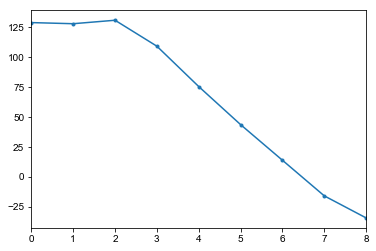

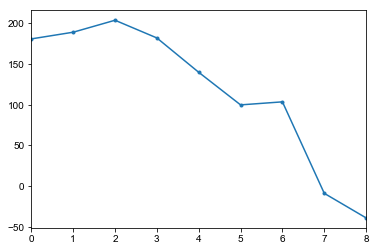

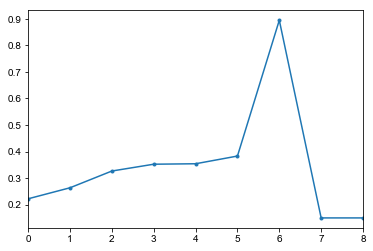

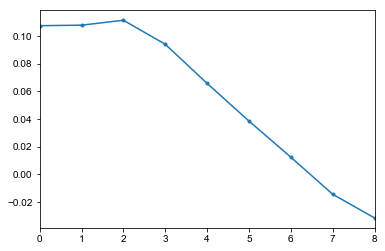

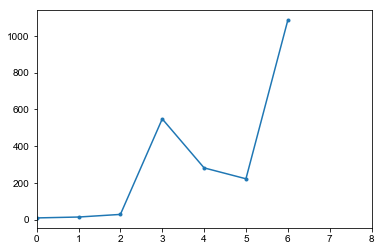

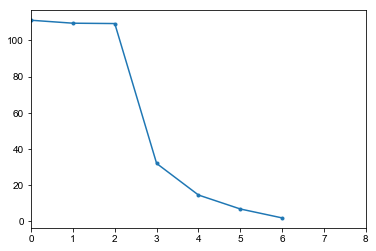

In [28]:
for name in trends:
    plt.figure()
    trends[name].plot(style='.-')
plt.show()

### Step Two: Parameter sweep on output, optimize cost

First, let's create a data structure to store the results.

In [82]:
q_fraction_range = [1, 0.999, 0.99, 0.95, 0.9, 0.8, 0.5, 0.2, 0.1]

In [29]:
opts2 = pandas.DataFrame(index=pandas.MultiIndex.from_product([t_heat_reject_range,
                                                               q_fraction_range],
                                                             names=['T_r','q_frac']),
                        columns=['Q'] + trendnames + ['opt', ] )

Draw in the results from step one. (TODO: re-arrange all this...)

In [ ]:
for tr,opt in zip(t_heat_reject_range, opts):
    opts2.opt[(tr,1)] = opt
    ch = system_aqua1.makeChiller(opt.x)
    opts2.at[(tr,1),'Q'] = ch.Q_evap
    # TODO: Would like to add constraints, eventually

In [17]:
ch = system_aqua1.makeChiller(opt['x'])
opts2.at[(tr,1),'Q'] = ch.Q_evap

In [91]:
#opts2 = opts2.append(pandas.DataFrame(
#    index=pandas.MultiIndex.from_product([t_heat_reject_range,
#                                          [0.99, 0.999]],
#                                        names=['T_r','q_frac'])))
#opts2 = opts2.reindex(pandas.MultiIndex.from_product([t_heat_reject_range,
#                                          [1.0, 0.999, 0.99, 0.95, 0.9, 0.8, 0.5, 0.2, 0.1]],
#                                        names=['T_r','q_frac']))
#opts2 = opts2.append(pandas.DataFrame(
#    columns=['x0']))

In [106]:
opts2

Q      Q_evap       Q_gen     UA_abs    UA_cond  \
T_r    q_frac                                                             
293.15 1.000   128.977391  139.030979  224.152493  11.212531  13.804200   
       0.999          NaN  128.850846  208.146698  10.074983  12.288194   
       0.990          NaN  127.727146  206.303627   9.937906  12.002823   
       0.950          NaN  122.506918  198.160173   9.383314  11.439602   
       0.900          NaN  116.083945  187.718626   8.712479  10.539891   
       0.800          NaN  103.182068  167.087555   7.498749   9.106962   
       0.500          NaN   64.490906  104.862444   4.231820   5.196822   
       0.200          NaN   25.799808   41.759857   1.563582   1.941573   
       0.100          NaN   17.842693   30.800730   1.073663   1.225104   
298.15 1.000   128.034153  139.030979  224.152493  15.268645  30.220725   
       0.999          NaN  127.907966  206.789067  13.361890  23.989460   
       0.990          NaN  126.761069  204.836576  13.178693  23.706205   
       0.950          NaN  121.655511  196.452285  12.452582  22.770665   
       0.900          NaN  115.233004  186.403077  11.478880  20.500358   
       0.800          NaN  102.405130  165.817912   9.774421  16.693889   
       0.500          NaN   64.002275  103.985507   5.382171   8.802706   
       0.200          NaN   25.618329   41.429030   1.962857   3.139382   
       0.100          NaN   17.751018   30.679645   1.318054   1.828488   
303.15 1.000   138.393588  138.393588  217.446603  55.956375  32.683350   
       0.999          NaN  138.181477  217.384679  53.908811  31.737253   
       0.990          NaN  137.001793  215.539605  52.697382  31.154525   
       0.950          NaN  131.486300  207.117045  45.753580  27.461878   
       0.900          NaN  124.581833  197.008719  39.893876  24.348429   
       0.800          NaN  110.741957  174.926495  31.759606  20.495802   
       0.500          NaN   69.224533  109.188935  15.173913  10.445855   
       0.200          NaN   27.718114   43.722647   4.927487   3.339761   
       0.100          NaN   15.079187   27.925294   2.120082   1.472197   
308.15 1.000   109.223406  109.223404  182.204157  30.296029  25.019476   
       0.999          NaN  109.146510  182.022433  29.515323  25.019928   
       0.990          NaN  108.131460  180.641250  28.356381  24.582613   
...                   ...         ...         ...        ...        ...   
318.15 0.500    21.794788   21.794787   49.885074   5.174484   3.063267   
       0.200     8.717616    8.717616   22.243496   2.110073   1.076134   
       0.100     4.358804    4.358804   15.797190   1.506274   0.445596   
323.15 1.000    13.745885   13.745886  103.581624  26.707226   1.921627   
       0.999          NaN   13.684448  103.184644  25.984453   1.880111   
       0.990          NaN   13.608789  103.042546  25.942423   1.869253   
       0.950     2.562008    2.562007   27.935285   4.181383   0.333417   
       0.900     2.562080    2.562081   27.925857   4.179723   0.333429   
       0.800     4.134768    4.134767   40.844280   6.503261   0.541400   
       0.500     6.874225    6.874225   50.113964   8.248145   0.952594   
       0.200     2.748488    2.748490   25.211171   3.707146   0.365871   
       0.100     1.374703    1.374704   17.299685   2.492995   0.178903   
328.15 1.000   -16.075082  -16.075082   -8.981001        NaN        NaN   
       0.999          NaN  -16.075082   -8.985155        NaN        NaN   
       0.990          NaN  -16.075082   -8.985155        NaN        NaN   
       0.950          NaN  -16.075082   -8.981001        NaN        NaN   
       0.900          NaN  -16.075082   -8.981001        NaN        NaN   
       0.800          NaN  -16.075082   -8.981001        NaN        NaN   
       0.500          NaN  -16.075082   -8.981001        NaN        NaN   
       0.200          NaN  -16.075082   -8.981001        NaN        NaN   
       0.100          NaN  -16.075082   -8.981001

In [23]:
opts2.iloc[14].opt['x']

array([   0.50161916,  278.09540996,  310.93375504,  311.19410773,
        307.19537607,  373.42971292])

<IPython.core.display.Javascript object>


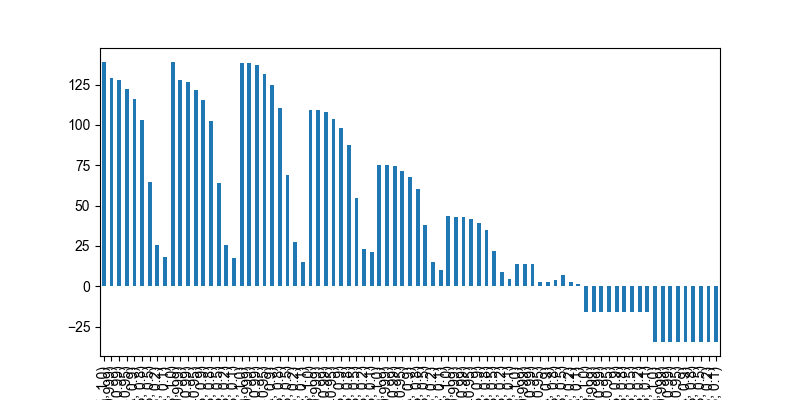

In [116]:
plt.figure(figsize=[8,4])
opts2.Q_evap.plot.bar()
plt.show()

<IPython.core.display.Javascript object>


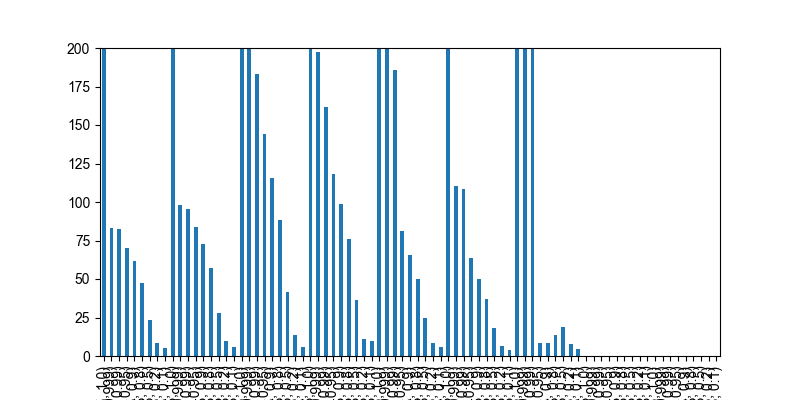

In [117]:
plt.figure(figsize=[8,4])
opts2.UA_total.plot.bar()
plt.ylim(0,200)
plt.show()

In [111]:
fname = 'optimize_trials2_5_data.csv'
if False:
    opts2.to_csv(fname)
if False:
    opts2 = pandas.read_csv(fname, header=0, index_col=[0,1])
if False:
    from numpy import array, inf, nan
    # If all the opt entries are __repr__ output from OptimizeResult (oops)
    from util import optimize_result_repr_to_dict
    for i,o in opts2.opt.items():
        if type(o) == str:
            print("Making a correction at index {} of opt={}".format(i,o))
            if o.startswith('{'):
                print("Hm, I think it's a dictionary.")
                d = eval(o)
                opts2.opt[i] = d
            else:
                # If all the opt entries are strings as read by read_csv
                print("By elimination, probably an OptimizeResult.__repr__() output.")
                d = optimize_result_repr_to_dict(o)
                opts2.opt[i] = d


In [39]:
a='aardvark'
a.startswith('aa')

True

In [47]:
dry_run = True
for i,index in enumerate(opts2.index):
    tr,qf = index
    q_max = opts2.Q[(tr,1)]
    q_goal = q_max * qf
    print("Case {}, T_heat_reject = {} K, Q_fraction = {}, Q_goal = {}".format(i, tr, qf, q_goal))

    if opts2.opt[index] is numpy.nan or opts2.opt[index] is None:
        xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_B(bdry,q_goal)
        x = numpy.array([0.05, 278.45, tr+7, tr+8, tr+5, 395.15])
        
        if not dry_run:
            P.n_calls = 7*30
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            print("First pass and we have this ... ")
            display_result(x)

            P.n_calls = 7*40
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            print("Second pass and we have this ... ")
            display_result(x)

            P.n_calls = 7*50
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.01})
            x = opt.x
            print("Third pass and we have this ... ")
            display_result(x)

            opts2.opt[index] = opt
        

Case 0, T_heat_reject = 293.15 K, Q_fraction = 1.0, Q_goal = 128.977391498
Case 1, T_heat_reject = 293.15 K, Q_fraction = 0.95, Q_goal = 122.5285219231
Case 2, T_heat_reject = 293.15 K, Q_fraction = 0.9, Q_goal = 116.0796523482
Case 3, T_heat_reject = 293.15 K, Q_fraction = 0.8, Q_goal = 103.18191319840001
Case 4, T_heat_reject = 293.15 K, Q_fraction = 0.5, Q_goal = 64.488695749
Case 5, T_heat_reject = 293.15 K, Q_fraction = 0.2, Q_goal = 25.795478299600003
Case 6, T_heat_reject = 293.15 K, Q_fraction = 0.1, Q_goal = 12.897739149800001
Case 7, T_heat_reject = 298.15 K, Q_fraction = 1.0, Q_goal = 128.034152931
Case 8, T_heat_reject = 298.15 K, Q_fraction = 0.95, Q_goal = 121.63244528444999
Case 9, T_heat_reject = 298.15 K, Q_fraction = 0.9, Q_goal = 115.23073763789999
Case 10, T_heat_reject = 298.15 K, Q_fraction = 0.8, Q_goal = 102.4273223448
Case 11, T_heat_reject = 298.15 K, Q_fraction = 0.5, Q_goal = 64.0170764655
Case 12, T_heat_reject = 298.15 K, Q_fraction = 0.2, Q_goal = 25.6068

In [96]:
d=dict()
d[(303.15,0.95)] = array([   0.47920246,  278.17258004,  311.03722458,  311.29853349,
        307.31608332,  373.4217932 ])

d[(303.15,0.9)] = array([   0.46042825,  278.06261986,  311.12471959,  311.39078344,
        307.40903514,  373.42125787])

d[(303.15,0.8)] = array([   0.40928524,  278.05976775,  311.12458983,  311.38278494,
        307.41282053,  373.42343252])

d[(303.15,0.5)] = array([  2.54650350e-01,   2.78112131e+02,   3.11070930e+02,
         3.11363072e+02,   3.07423492e+02,   3.73444409e+02])

d[(303.15,0.2)] = array([  1.02384404e-01,   2.78082311e+02,   3.11054415e+02,
         3.11364635e+02,   3.07485941e+02,   3.73429532e+02])

d[(303.15,0.1)] = array([  1.00000000e-01,   2.77188460e+02,   3.11580120e+02,
         3.11680120e+02,   3.08320712e+02,   3.72906164e+02])
for tr in t_heat_reject_range:
    opts2.at[(tr,0.99),'x0'] = opts2.at[(tr,0.95),'opt']['x']
    opts2.at[(tr,0.999),'x0'] = opts2.at[(tr,0.95),'opt']['x']

In [99]:
opts2.loc[(293.15,0.99)]

Q                                                         NaN
Q_evap                                                    NaN
Q_gen                                                     NaN
UA_abs                                                    NaN
UA_cond                                                   NaN
UA_evap                                                   NaN
UA_gen                                                    NaN
UA_rect                                                   NaN
UA_total                                                  NaN
m_refrig                                                  NaN
m_rich                                                    NaN
opt                                                       NaN
x0          [0.53572866, 278.00357511, 306.62700236, 315.8...
Name: (293.15, 0.99), dtype: object

In [100]:
dry_run = False
for i,index in enumerate(opts2.index):
    tr,qf = index
    
    q_max = opts2.Q[(tr,1)]
    q_goal = q_max * qf
    print("Case {}, T_heat_reject = {} K, Q_fraction = {}, Q_goal = {}".format(i, tr, qf, q_goal))

    if opts2.opt[index] in [None, nan]:
        xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
        bdry = system_aqua1.makeBoundary(xB)
        P = Problem_2_5_B(bdry,q_goal)
        if index in d:
            x = d[index].copy()
        else:
            x = opts2.opt[(tr,1)]['x'].copy()
        print("Initial x = ")
        display(x)
        
        if not dry_run:
            print("Running first pass optimization ... ")
            P.n_calls = 7*10
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            display_result(x)

            print("Running second pass optimization ... ")
            P.n_calls = 7*30
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.1})
            x = opt.x
            display_result(x)

            print("Running third pass optimization ... ")
            P.n_calls = 7*50
            opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                                          constraints=P.constraints,
                                          options={'disp':True,'maxiter':50,'rhobeg':0.01})
            x = opt.x
            display_result(x)

            opts2.at[index,'opt'] = dict(opt)
    

Case 0, T_heat_reject = 293.15 K, Q_fraction = 1.0, Q_goal = 128.977391498
Case 1, T_heat_reject = 293.15 K, Q_fraction = 0.999, Q_goal = 128.848414106502
Initial x = 


array([   0.60027398,  278.05790444,  306.47787741,  315.70000125,
        312.99011322,  371.70586647])

Running first pass optimization ... 


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


X = 


array([   0.56294402,  278.02516366,  306.6002688 ,  315.7888991 ,
        313.07249626,  371.73183276])

name,deltaT,epsilon,UA,Q
gen,3.47806,0.934857,18.0139,208.587
rect,21.6868,0.628411,0.542798,14.9209
abs,18.4894,0.45921,10.0619,196.834
cond,7.87399,0.947143,12.2915,126.536
evap,0.643532,0.982826,42.9291,129.011
total,0,0,83.8392,0


Running second pass optimization ... 
X = 


array([   0.5603065 ,  278.0266606 ,  306.58327617,  315.92210222,
        313.00630168,  371.70678101])

name,deltaT,epsilon,UA,Q
gen,3.65513,0.931634,17.6063,208.154
rect,21.8022,0.62558,0.536813,14.8055
abs,18.4062,0.459854,10.0745,196.456
cond,7.86359,0.94723,12.2963,126.439
evap,0.651188,0.98283,42.7284,128.859
total,0,0,83.2423,0


Running third pass optimization ... 
X = 


array([   0.56031659,  278.02647954,  306.58900124,  315.93538347,
        313.00309291,  371.70690732])

name,deltaT,epsilon,UA,Q
gen,3.65595,0.931618,17.6062,208.147
rect,21.8143,0.625588,0.536476,14.8018
abs,18.405,0.459864,10.075,196.451
cond,7.86972,0.947209,12.2882,126.433
evap,0.651828,0.982829,42.7123,128.851
total,0,0,83.2182,0


Case 2, T_heat_reject = 293.15 K, Q_fraction = 0.99, Q_goal = 127.68761758302
Initial x = 


array([   0.60027398,  278.05790444,  306.47787741,  315.70000125,
        312.99011322,  371.70586647])

Running first pass optimization ... 
X = 


array([   0.55639401,  278.02454248,  306.60240468,  315.7906356 ,
        313.06238456,  371.72940385])

name,deltaT,epsilon,UA,Q
gen,4.03517,0.924407,16.8068,206.213
rect,21.6885,0.628415,0.534154,14.7469
abs,18.4926,0.456332,9.91013,194.598
cond,7.94097,0.947135,12.1016,125.104
evap,0.731426,0.982825,40.7893,127.553
total,0,0,80.142,0


Running second pass optimization ... 
X = 


array([   0.55554465,  278.11394666,  306.70014314,  315.86429773,
        313.02579572,  371.71967895])

name,deltaT,epsilon,UA,Q
gen,4.05924,0.924014,16.7668,206.283
rect,21.7617,0.630354,0.532332,14.7151
abs,18.4514,0.457044,9.93821,194.723
cond,8.03135,0.946744,12.0051,125.257
evap,0.632005,0.982994,43.0549,127.727
total,0,0,82.2973,0


Running third pass optimization ... 
X = 


array([   0.55576348,  278.11067493,  306.70213363,  315.87593835,
        313.02698038,  371.71804193])

name,deltaT,epsilon,UA,Q
gen,4.05019,0.924178,16.7853,206.304
rect,21.772,0.630293,0.532172,14.7156
abs,18.4557,0.457009,9.93791,194.741
cond,8.03338,0.946738,12.0028,125.26
evap,0.635261,0.982988,42.9755,127.727
total,0,0,82.2337,0


Case 3, T_heat_reject = 293.15 K, Q_fraction = 0.95, Q_goal = 122.5285219231
Case 4, T_heat_reject = 293.15 K, Q_fraction = 0.9, Q_goal = 116.0796523482
Case 5, T_heat_reject = 293.15 K, Q_fraction = 0.8, Q_goal = 103.18191319840001
Case 6, T_heat_reject = 293.15 K, Q_fraction = 0.5, Q_goal = 64.488695749
Case 7, T_heat_reject = 293.15 K, Q_fraction = 0.2, Q_goal = 25.795478299600003
Case 8, T_heat_reject = 293.15 K, Q_fraction = 0.1, Q_goal = 12.897739149800001
Case 9, T_heat_reject = 298.15 K, Q_fraction = 1.0, Q_goal = 128.034152931
Case 10, T_heat_reject = 298.15 K, Q_fraction = 0.999, Q_goal = 127.906118778069
Initial x = 


array([   0.60027398,  278.05790444,  306.47787741,  315.70000125,
        312.99011322,  371.70586647])

Running first pass optimization ... 
X = 


array([   0.55826718,  278.01550027,  306.60660379,  315.79679365,
        313.07444615,  371.72630316])

name,deltaT,epsilon,UA,Q
gen,3.90778,0.926772,17.0655,206.68
rect,16.6943,0.644837,0.656847,14.7898
abs,13.5124,0.535158,13.344,195.031
cond,2.93444,0.965001,24.7267,125.342
evap,0.725866,0.982808,40.9348,127.796
total,0,0,96.7278,0


Running second pass optimization ... 
X = 


array([   0.55863411,  278.10793583,  306.73941477,  315.88116865,
        313.05773909,  371.72238996])

name,deltaT,epsilon,UA,Q
gen,3.86706,0.927539,17.1628,206.863
rect,16.7799,0.643525,0.655172,14.7866
abs,13.5092,0.535506,13.3735,195.257
cond,3.06012,0.964523,24.0813,125.483
evap,0.623225,0.982981,43.3009,127.974
total,0,0,98.5736,0


Running third pass optimization ... 
X = 


array([   0.5587135 ,  278.1075453 ,  306.75274496,  315.89280928,
        313.05812968,  371.72075047])

name,deltaT,epsilon,UA,Q
gen,3.87579,0.927364,17.1471,206.789
rect,16.7913,0.643476,0.65458,14.7839
abs,13.517,0.535274,13.3619,195.188
cond,3.07653,0.964475,23.9895,125.416
evap,0.627558,0.98298,43.1858,127.908
total,0,0,98.3388,0


Case 11, T_heat_reject = 298.15 K, Q_fraction = 0.99, Q_goal = 126.75381140168999
Initial x = 


array([   0.60027398,  278.05790444,  306.47787741,  315.70000125,
        312.99011322,  371.70586647])

Running first pass optimization ... 
X = 


array([   0.55181815,  278.02798499,  306.59222496,  315.7932683 ,
        313.06519978,  371.72917491])

name,deltaT,epsilon,UA,Q
gen,4.41771,0.917231,16.0861,204.587
rect,16.6899,0.644569,0.646988,14.625
abs,13.497,0.532918,13.1615,193.062
cond,2.97457,0.965053,24.3627,124.141
evap,0.787131,0.982832,39.555,126.564
total,0,0,93.8123,0


Running second pass optimization ... 
X = 


array([   0.55267479,  278.12683008,  306.72541357,  315.88154955,
        313.06901595,  371.72526841])

name,deltaT,epsilon,UA,Q
gen,4.34896,0.918502,16.2172,204.83
rect,16.779,0.643312,0.645695,14.6318
abs,13.5171,0.532902,13.1774,193.337
cond,3.09965,0.964575,23.738,124.306
evap,0.676838,0.983017,41.8829,126.763
total,0,0,95.6611,0


Running third pass optimization ... 
X = 


array([   0.55278271,  278.12605274,  306.73155036,  315.8948308 ,
        313.06636182,  371.72370705])

name,deltaT,epsilon,UA,Q
gen,4.34569,0.918561,16.2243,204.837
rect,16.7912,0.643156,0.645308,14.6298
abs,13.5174,0.532906,13.1787,193.345
cond,3.10596,0.964553,23.7062,124.305
evap,0.67775,0.983016,41.862,126.761
total,0,0,95.6165,0


Case 12, T_heat_reject = 298.15 K, Q_fraction = 0.95, Q_goal = 121.63244528444999
Case 13, T_heat_reject = 298.15 K, Q_fraction = 0.9, Q_goal = 115.23073763789999
Case 14, T_heat_reject = 298.15 K, Q_fraction = 0.8, Q_goal = 102.4273223448
Case 15, T_heat_reject = 298.15 K, Q_fraction = 0.5, Q_goal = 64.0170764655
Case 16, T_heat_reject = 298.15 K, Q_fraction = 0.2, Q_goal = 25.6068305862
Case 17, T_heat_reject = 298.15 K, Q_fraction = 0.1, Q_goal = 12.8034152931
Case 18, T_heat_reject = 303.15 K, Q_fraction = 1.0, Q_goal = 138.3935882734963
Case 19, T_heat_reject = 303.15 K, Q_fraction = 0.999, Q_goal = 138.25519468522282
Initial x = 


array([   0.50161916,  278.09540996,  310.93375504,  311.19410773,
        307.19537607,  373.42971292])

Running first pass optimization ... 
X = 


array([   0.50156202,  278.09383499,  311.01655391,  311.27223273,
        307.29537607,  373.42971292])

name,deltaT,epsilon,UA,Q
gen,3.97524,0.928615,18.2511,216.106
rect,5.30193,0.886622,2.09564,18.7791
abs,2.87905,0.851652,52.8361,207.213
cond,1.9727,0.964707,31.2592,128.159
evap,0.0800955,0.990342,77.6325,137.287
total,0,0,182.075,0


Running second pass optimization ... 
X = 


array([   0.5028251 ,  278.11916078,  311.01602138,  311.27175742,
        307.29645599,  373.53128847])

name,deltaT,epsilon,UA,Q
gen,3.686,0.933829,18.9268,217.385
rect,5.27542,0.886641,2.12526,18.8831
abs,2.84039,0.854093,53.9088,208.446
cond,1.93249,0.964709,31.7373,128.997
evap,0.00140644,0.99983,145.154,138.181
total,0,0,251.852,0


Running third pass optimization ... 
X = 


array([   0.5028251 ,  278.11916078,  311.01602138,  311.27175742,
        307.29645599,  373.53128847])

name,deltaT,epsilon,UA,Q
gen,3.686,0.933829,18.9268,217.385
rect,5.27542,0.886641,2.12526,18.8831
abs,2.84039,0.854093,53.9088,208.446
cond,1.93249,0.964709,31.7373,128.997
evap,0.00140644,0.99983,145.154,138.181
total,0,0,251.852,0


Case 20, T_heat_reject = 303.15 K, Q_fraction = 0.99, Q_goal = 137.00965239076135
Initial x = 


array([   0.50161916,  278.09540996,  310.93375504,  311.19410773,
        307.19537607,  373.42971292])

Running first pass optimization ... 
X = 


array([   0.49853345,  278.09366085,  311.0156352 ,  311.26925716,
        307.29612714,  373.42894983])

name,deltaT,epsilon,UA,Q
gen,4.27219,0.92326,17.625,214.795
rect,5.29302,0.887584,2.07778,18.686
abs,2.89018,0.85039,52.0018,205.955
cond,2.00864,0.964705,30.8271,127.361
evap,0.130142,0.984307,69.5182,136.454
total,0,0,172.05,0


Running second pass optimization ... 
X = 


array([   0.49867563,  278.12021925,  311.01563519,  311.29035568,
        307.29612714,  373.52894983])

name,deltaT,epsilon,UA,Q
gen,4.0942,0.926474,18.0034,215.592
rect,5.59227,0.878234,1.99849,18.5492
abs,2.85463,0.85243,52.7668,206.728
cond,1.98237,0.964758,31.2317,128.114
evap,0.0683388,0.991733,80.2335,137.045
total,0,0,184.234,0


Running third pass optimization ... 
X = 


array([   0.49866386,  278.11813382,  311.01900357,  311.28832443,
        307.29648162,  373.52730805])

name,deltaT,epsilon,UA,Q
gen,4.10211,0.926326,17.9867,215.54
rect,5.52008,0.880567,2.01977,18.5941
abs,2.85804,0.852249,52.6974,206.677
cond,1.9877,0.964732,31.1545,128.025
evap,0.0730008,0.991172,79.1345,137.002
total,0,0,182.993,0


Case 21, T_heat_reject = 303.15 K, Q_fraction = 0.95, Q_goal = 131.47390885982148
Case 22, T_heat_reject = 303.15 K, Q_fraction = 0.9, Q_goal = 124.55422944614668
Case 23, T_heat_reject = 303.15 K, Q_fraction = 0.8, Q_goal = 110.71487061879705
Case 24, T_heat_reject = 303.15 K, Q_fraction = 0.5, Q_goal = 69.19679413674815
Case 25, T_heat_reject = 303.15 K, Q_fraction = 0.2, Q_goal = 27.678717654699263
Case 26, T_heat_reject = 303.15 K, Q_fraction = 0.1, Q_goal = 13.839358827349631
Case 27, T_heat_reject = 308.15 K, Q_fraction = 1.0, Q_goal = 109.223406258
Case 28, T_heat_reject = 308.15 K, Q_fraction = 0.999, Q_goal = 109.114182851742
Initial x = 


array([  3.52329016e-01,   2.78721861e+02,   3.15129658e+02,
         3.16155350e+02,   3.13100060e+02,   3.95277134e+02])

Running first pass optimization ... 


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


X = 


array([  3.52329016e-01,   2.78742173e+02,   3.15129658e+02,
         3.16232694e+02,   3.13200060e+02,   3.95277134e+02])

name,deltaT,epsilon,UA,Q
gen,0.0559352,0.998716,117.959,181.837
rect,8.05932,0.823149,1.14311,17.1273
abs,2.32798,0.88899,29.4392,171.596
cond,2.37715,0.969215,24.9043,102.656
evap,1.1314,0.983897,32.0103,108.925
total,0,0,205.455,0


Running second pass optimization ... 
X = 


array([  3.52329016e-01,   2.78821861e+02,   3.15129658e+02,
         3.16322538e+02,   3.13212560e+02,   3.95277134e+02])

name,deltaT,epsilon,UA,Q
gen,0.0529037,0.998788,120.051,182.143
rect,8.16226,0.819948,1.12954,17.0621
abs,2.31441,0.889529,29.6224,171.912
cond,2.36373,0.969234,25.0521,103.01
evap,1.03409,0.984054,33.3417,109.226
total,0,0,209.196,0


Running third pass optimization ... 
X = 


array([  3.52173304e-01,   2.78823580e+02,   3.15129502e+02,
         3.16330428e+02,   3.13222560e+02,   3.95277055e+02])

name,deltaT,epsilon,UA,Q
gen,0.0718946,0.998352,108.428,182.022
rect,8.17093,0.81969,1.12702,17.0491
abs,2.32536,0.889044,29.5153,171.795
cond,2.36702,0.969236,25.0199,102.941
evap,1.03712,0.984057,33.2891,109.147
total,0,0,197.38,0


Case 29, T_heat_reject = 308.15 K, Q_fraction = 0.99, Q_goal = 108.13117219541999
Initial x = 


array([  3.52329016e-01,   2.78721861e+02,   3.15129658e+02,
         3.16155350e+02,   3.13100060e+02,   3.95277134e+02])

Running first pass optimization ... 
X = 


array([  3.52329016e-01,   2.78742173e+02,   3.15129658e+02,
         3.16232694e+02,   3.13200060e+02,   3.95277134e+02])

name,deltaT,epsilon,UA,Q
gen,0.0559352,0.998716,117.959,181.837
rect,8.05932,0.823149,1.14311,17.1273
abs,2.32798,0.88899,29.4392,171.596
cond,2.37715,0.969215,24.9043,102.656
evap,1.1314,0.983897,32.0103,108.925
total,0,0,205.455,0


Running second pass optimization ... 
X = 


array([  3.52329016e-01,   2.78762486e+02,   3.15129658e+02,
         3.16310038e+02,   3.13300060e+02,   3.95277134e+02])

name,deltaT,epsilon,UA,Q
gen,0.059205,0.998638,115.801,181.452
rect,8.14848,0.820561,1.12577,17.072
abs,2.43706,0.884179,28.6288,171.192
cond,2.39008,0.969231,24.7886,102.433
evap,1.12899,0.983937,32.0021,108.628
total,0,0,202.347,0


Running third pass optimization ... 
X = 


array([  3.50832723e-01,   2.78760183e+02,   3.15128820e+02,
         3.16318818e+02,   3.13307728e+02,   3.95278336e+02])

name,deltaT,epsilon,UA,Q
gen,0.236406,0.994561,76.0366,180.641
rect,8.15826,0.820244,1.11603,16.9934
abs,2.44627,0.883779,28.3564,170.422
cond,2.41093,0.969237,24.5826,101.972
evap,1.16097,0.983933,31.5397,108.131
total,0,0,161.631,0


Case 30, T_heat_reject = 308.15 K, Q_fraction = 0.95, Q_goal = 103.76223594509999
Case 31, T_heat_reject = 308.15 K, Q_fraction = 0.9, Q_goal = 98.3010656322
Case 32, T_heat_reject = 308.15 K, Q_fraction = 0.8, Q_goal = 87.3787250064
Case 33, T_heat_reject = 308.15 K, Q_fraction = 0.5, Q_goal = 54.611703129
Case 34, T_heat_reject = 308.15 K, Q_fraction = 0.2, Q_goal = 21.8446812516
Case 35, T_heat_reject = 308.15 K, Q_fraction = 0.1, Q_goal = 10.9223406258
Case 36, T_heat_reject = 313.15 K, Q_fraction = 1.0, Q_goal = 75.4406886479
Case 37, T_heat_reject = 313.15 K, Q_fraction = 0.999, Q_goal = 75.3652479592521
Initial x = 


array([  3.54044716e-01,   2.78613434e+02,   3.20144922e+02,
         3.21158249e+02,   3.18082059e+02,   3.95246211e+02])

Running first pass optimization ... 
X = 


array([  3.54044716e-01,   2.78618122e+02,   3.20219922e+02,
         3.21235593e+02,   3.18182059e+02,   3.95246211e+02])

name,deltaT,epsilon,UA,Q
gen,0.0307868,0.999148,146.43,139.171
rect,8.07695,0.868742,0.812993,15.4423
abs,5.0309,0.764455,14.2716,129.628
cond,3.99186,0.966419,13.2056,69.6981
evap,3.2933,0.98346,14.3929,74.8517
total,0,0,189.113,0


Running second pass optimization ... 
X = 


array([  3.54044716e-01,   2.78718122e+02,   3.20219922e+02,
         3.21323093e+02,   3.18182059e+02,   3.95246211e+02])

name,deltaT,epsilon,UA,Q
gen,0.016786,0.999571,186.123,139.674
rect,8.17353,0.866145,0.807584,15.422
abs,5.03075,0.764846,14.3125,130.125
cond,3.97307,0.966442,13.3219,70.1565
evap,3.16783,0.983657,14.8285,75.2848
total,0,0,229.393,0


Running third pass optimization ... 
X = 


array([  3.54044506e-01,   2.78728117e+02,   3.20219880e+02,
         3.21333073e+02,   3.18182147e+02,   3.95256220e+02])

name,deltaT,epsilon,UA,Q
gen,0.00589488,0.999896,291.099,139.76
rect,8.18445,0.865859,0.807291,15.424
abs,5.03109,0.764926,14.3184,130.207
cond,3.97021,0.966445,13.3391,70.2233
evap,3.15397,0.983677,14.8803,75.3501
total,0,0,334.444,0


Case 38, T_heat_reject = 313.15 K, Q_fraction = 0.99, Q_goal = 74.686281761421
Initial x = 


array([  3.54044716e-01,   2.78613434e+02,   3.20144922e+02,
         3.21158249e+02,   3.18082059e+02,   3.95246211e+02])

Running first pass optimization ... 
X = 


array([  3.54044716e-01,   2.78618122e+02,   3.20226172e+02,
         3.21238718e+02,   3.18182059e+02,   3.95246211e+02])

name,deltaT,epsilon,UA,Q
gen,0.0309505,0.999143,146.132,139.147
rect,8.07975,0.869019,0.812858,15.4418
abs,5.0309,0.764422,14.2704,129.605
cond,3.99899,0.966394,13.1841,69.6771
evap,3.29447,0.98346,14.3869,74.8322
total,0,0,188.786,0


Running second pass optimization ... 
X = 


array([  3.54044716e-01,   2.78622809e+02,   3.20251172e+02,
         3.21328562e+02,   3.18194559e+02,   3.95246211e+02])

name,deltaT,epsilon,UA,Q
gen,0.0324505,0.999097,143.51,139.008
rect,8.17661,0.8676,0.802853,15.3935
abs,5.04343,0.763781,14.2397,129.475
cond,4.02863,0.966316,13.1001,69.6131
evap,3.29607,0.983468,14.3688,74.7275
total,0,0,186.021,0


Running third pass optimization ... 
X = 


array([  3.54046218e-01,   2.78624528e+02,   3.20261328e+02,
         3.21337702e+02,   3.18195887e+02,   3.95246133e+02])

name,deltaT,epsilon,UA,Q
gen,0.0325885,0.999093,143.274,138.97
rect,8.18569,0.867921,0.802169,15.3906
abs,5.04476,0.763678,14.2355,129.44
cond,4.0401,0.966277,13.0668,69.5838
evap,3.2961,0.983471,14.365,74.6983
total,0,0,185.743,0


Case 39, T_heat_reject = 313.15 K, Q_fraction = 0.95, Q_goal = 71.668654215505
Case 40, T_heat_reject = 313.15 K, Q_fraction = 0.9, Q_goal = 67.89661978311001
Case 41, T_heat_reject = 313.15 K, Q_fraction = 0.8, Q_goal = 60.352550918320006
Case 42, T_heat_reject = 313.15 K, Q_fraction = 0.5, Q_goal = 37.72034432395
Case 43, T_heat_reject = 313.15 K, Q_fraction = 0.2, Q_goal = 15.088137729580001
Case 44, T_heat_reject = 313.15 K, Q_fraction = 0.1, Q_goal = 7.544068864790001
Case 45, T_heat_reject = 318.15 K, Q_fraction = 1.0, Q_goal = 43.5890044449
Case 46, T_heat_reject = 318.15 K, Q_fraction = 0.999, Q_goal = 43.5454154404551
Initial x = 


array([  3.83060648e-01,   2.78607631e+02,   3.25139577e+02,
         3.26152322e+02,   3.23086708e+02,   3.95249477e+02])

Running first pass optimization ... 
X = 


array([  3.69224737e-01,   2.78593795e+02,   3.25253413e+02,
         3.26241158e+02,   3.23164975e+02,   3.95246018e+02])

name,deltaT,epsilon,UA,Q
gen,0.733871,0.969047,39.5357,95.1365
rect,8.09985,0.899997,0.452409,10.9911
abs,5.01181,0.69824,11.339,88.3847
cond,5.48295,0.964714,6.13174,37.9027
evap,5.32925,0.983207,6.37948,41.2237
total,0,0,63.8383,0


Running second pass optimization ... 
X = 


array([  3.69257935e-01,   2.78693716e+02,   3.25253405e+02,
         3.26341148e+02,   3.23164927e+02,   3.95346029e+02])

name,deltaT,epsilon,UA,Q
gen,0.581652,0.975624,43.9317,96.1721
rect,8.20985,0.897644,0.455645,11.1088
abs,5.01182,0.700168,11.422,89.3236
cond,5.45263,0.964744,6.26287,38.6059
evap,5.18641,0.983407,6.6202,41.9485
total,0,0,68.6924,0


Running third pass optimization ... 
X = 


array([  3.79277209e-01,   2.78703707e+02,   3.25253418e+02,
         3.26351128e+02,   3.23164951e+02,   3.95355937e+02])

name,deltaT,epsilon,UA,Q
gen,0.0989701,0.996188,84.8688,98.8862
rect,8.21457,0.897571,0.471398,11.424
abs,5.01185,0.700357,11.8515,91.8422
cond,5.40212,0.964745,6.47474,39.7228
evap,5.10397,0.983427,6.86722,43.1603
total,0,0,110.534,0


Case 47, T_heat_reject = 318.15 K, Q_fraction = 0.99, Q_goal = 43.153114400450995
Initial x = 


array([  3.83060648e-01,   2.78607631e+02,   3.25139577e+02,
         3.26152322e+02,   3.23086708e+02,   3.95249477e+02])

Running first pass optimization ... 
X = 


array([  3.69224737e-01,   2.78593795e+02,   3.25253413e+02,
         3.26241158e+02,   3.23164975e+02,   3.95246018e+02])

name,deltaT,epsilon,UA,Q
gen,0.733871,0.969047,39.5357,95.1365
rect,8.09985,0.899997,0.452409,10.9911
abs,5.01181,0.69824,11.339,88.3847
cond,5.48295,0.964714,6.13174,37.9027
evap,5.32925,0.983207,6.37948,41.2237
total,0,0,63.8383,0


Running second pass optimization ... 
X = 


array([  3.69256252e-01,   2.78693786e+02,   3.25253432e+02,
         3.26341129e+02,   3.23165051e+02,   3.95345974e+02])

name,deltaT,epsilon,UA,Q
gen,0.581812,0.975618,43.9266,96.171
rect,8.20985,0.897645,0.455638,11.1086
abs,5.01194,0.700162,11.4217,89.3226
cond,5.45268,0.964744,6.26274,38.6053
evap,5.18637,0.983407,6.62016,41.9479
total,0,0,68.6868,0


Running third pass optimization ... 
X = 


array([  3.79156872e-01,   2.78703786e+02,   3.25253433e+02,
         3.26348004e+02,   3.23165052e+02,   3.95354359e+02])

name,deltaT,epsilon,UA,Q
gen,0.106483,0.995871,82.5723,98.8476
rect,8.2131,0.897607,0.471229,11.4196
abs,5.01195,0.700337,11.8457,91.8066
cond,5.40289,0.964745,6.47147,39.7057
evap,5.10497,0.983427,6.86374,43.1421
total,0,0,108.224,0


Case 48, T_heat_reject = 318.15 K, Q_fraction = 0.95, Q_goal = 41.409554222655
Case 49, T_heat_reject = 318.15 K, Q_fraction = 0.9, Q_goal = 39.23010400041
Case 50, T_heat_reject = 318.15 K, Q_fraction = 0.8, Q_goal = 34.87120355592
Case 51, T_heat_reject = 318.15 K, Q_fraction = 0.5, Q_goal = 21.79450222245
Case 52, T_heat_reject = 318.15 K, Q_fraction = 0.2, Q_goal = 8.71780088898
Case 53, T_heat_reject = 318.15 K, Q_fraction = 0.1, Q_goal = 4.35890044449
Case 54, T_heat_reject = 323.15 K, Q_fraction = 1.0, Q_goal = 13.7458854907
Case 55, T_heat_reject = 323.15 K, Q_fraction = 0.999, Q_goal = 13.7321396052093
Initial x = 


array([   0.89470281,  278.75287191,  329.92023585,  331.08771106,
        327.94495262,  395.32047985])

Running first pass optimization ... 
X = 


array([   0.8808669 ,  278.739036  ,  330.03407176,  331.17654697,
        328.02322002,  395.31702087])

name,deltaT,epsilon,UA,Q
gen,0.98186,0.960169,83.6942,98.9119
rect,7.92487,0.910854,0.128374,3.87922
abs,3.32266,0.703071,24.5856,98.6339
cond,6.48637,0.966029,1.57006,10.4542
evap,6.96183,0.983296,1.58374,11.5162
total,0,0,111.562,0


Running second pass optimization ... 
X = 


array([   0.88078564,  278.83899886,  330.03406688,  331.27651101,
        328.02324027,  395.41700385])

name,deltaT,epsilon,UA,Q
gen,0.336723,0.986357,214.045,101.737
rect,7.97041,0.91023,0.149195,4.47498
abs,3.29736,0.709625,25.2795,101.025
cond,6.41486,0.966042,1.83165,12.1221
evap,6.75275,0.983499,1.87588,13.3473
total,0,0,243.181,0


Running third pass optimization ... 
X = 


array([   0.89084395,  278.84894336,  330.03408895,  331.2864697 ,
        328.02320415,  395.42699926])

name,deltaT,epsilon,UA,Q
gen,0.0031643,0.999872,1879.22,103.185
rect,7.97504,0.910169,0.15312,4.58586
abs,3.2025,0.718386,25.9845,102.421
cond,6.40166,0.966043,1.88011,12.4288
evap,6.72268,0.983518,1.92876,13.6844
total,0,0,1909.17,0


Case 56, T_heat_reject = 323.15 K, Q_fraction = 0.99, Q_goal = 13.608426635792998
Initial x = 


array([   0.89470281,  278.75287191,  329.92023585,  331.08771106,
        327.94495262,  395.32047985])

Running first pass optimization ... 
X = 


array([   0.8808669 ,  278.739036  ,  330.03407176,  331.17654697,
        328.02322002,  395.31702087])

name,deltaT,epsilon,UA,Q
gen,0.98186,0.960169,83.6942,98.9119
rect,7.92487,0.910854,0.128374,3.87922
abs,3.32266,0.703071,24.5856,98.6339
cond,6.48637,0.966029,1.57006,10.4542
evap,6.96183,0.983296,1.58374,11.5162
total,0,0,111.562,0


Running second pass optimization ... 
X = 


array([   0.88092429,  278.83897607,  330.03401873,  331.27655539,
        328.02321958,  395.41703605])

name,deltaT,epsilon,UA,Q
gen,0.333164,0.986502,215.589,101.754
rect,7.97041,0.910227,0.149228,4.4759
abs,3.29606,0.70974,25.2885,101.042
cond,6.4147,0.966043,1.83206,12.1246
evap,6.75261,0.983499,1.87628,13.3501
total,0,0,244.735,0


Running third pass optimization ... 
X = 


array([   0.89065731,  278.84904599,  330.03401217,  331.28497756,
        328.02318032,  395.41709997])

name,deltaT,epsilon,UA,Q
gen,0.0401992,0.998372,671.598,103.043
rect,7.9743,0.910181,0.152227,4.56054
abs,3.2052,0.71797,25.9424,102.296
cond,6.40455,0.966044,1.86925,12.3601
evap,6.7271,0.983518,1.91749,13.6088
total,0,0,701.48,0


Case 57, T_heat_reject = 323.15 K, Q_fraction = 0.95, Q_goal = 13.058591216164999
Case 58, T_heat_reject = 323.15 K, Q_fraction = 0.9, Q_goal = 12.37129694163
Case 59, T_heat_reject = 323.15 K, Q_fraction = 0.8, Q_goal = 10.99670839256
Case 60, T_heat_reject = 323.15 K, Q_fraction = 0.5, Q_goal = 6.87294274535
Case 61, T_heat_reject = 323.15 K, Q_fraction = 0.2, Q_goal = 2.74917709814
Case 62, T_heat_reject = 323.15 K, Q_fraction = 0.1, Q_goal = 1.37458854907
Case 63, T_heat_reject = 328.15 K, Q_fraction = 1.0, Q_goal = -16.0750822067
Case 64, T_heat_reject = 328.15 K, Q_fraction = 0.999, Q_goal = -16.0590071244933
Initial x = 


array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

Running first pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Running second pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Running third pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 65, T_heat_reject = 328.15 K, Q_fraction = 0.99, Q_goal = -15.914331384633
Initial x = 


array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

Running first pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Running second pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Running third pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.35150000e+02,
         3.36150000e+02,   3.33150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 66, T_heat_reject = 328.15 K, Q_fraction = 0.95, Q_goal = -15.271328096364998
Case 67, T_heat_reject = 328.15 K, Q_fraction = 0.9, Q_goal = -14.46757398603
Case 68, T_heat_reject = 328.15 K, Q_fraction = 0.8, Q_goal = -12.86006576536
Case 69, T_heat_reject = 328.15 K, Q_fraction = 0.5, Q_goal = -8.03754110335
Case 70, T_heat_reject = 328.15 K, Q_fraction = 0.2, Q_goal = -3.21501644134
Case 71, T_heat_reject = 328.15 K, Q_fraction = 0.1, Q_goal = -1.60750822067
Case 72, T_heat_reject = 333.15 K, Q_fraction = 1.0, Q_goal = -34.5410243078
Case 73, T_heat_reject = 333.15 K, Q_fraction = 0.999, Q_goal = -34.5064832834922
Initial x = 


array([  1.50000000e-01,   2.78450000e+02,   3.40150000e+02,
         3.41150000e+02,   3.38150000e+02,   3.95150000e+02])

Running first pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.40150000e+02,
         3.41150000e+02,   3.38150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Running second pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.40150000e+02,
         3.41150000e+02,   3.38150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Running third pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.40150000e+02,
         3.41150000e+02,   3.38150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 74, T_heat_reject = 333.15 K, Q_fraction = 0.99, Q_goal = -34.195614064722
Initial x = 


array([  1.50000000e-01,   2.78450000e+02,   3.40150000e+02,
         3.41150000e+02,   3.38150000e+02,   3.95150000e+02])

Running first pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.40150000e+02,
         3.41150000e+02,   3.38150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Running second pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.40150000e+02,
         3.41150000e+02,   3.38150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Running third pass optimization ... 
X = 


array([  1.50000000e-01,   2.78450000e+02,   3.40150000e+02,
         3.41150000e+02,   3.38150000e+02,   3.95150000e+02])

ValueError('In rectifier, net mass or ammonia flow is negative.')

Case 75, T_heat_reject = 333.15 K, Q_fraction = 0.95, Q_goal = -32.81397309241
Case 76, T_heat_reject = 333.15 K, Q_fraction = 0.9, Q_goal = -31.08692187702
Case 77, T_heat_reject = 333.15 K, Q_fraction = 0.8, Q_goal = -27.632819446240003
Case 78, T_heat_reject = 333.15 K, Q_fraction = 0.5, Q_goal = -17.2705121539
Case 79, T_heat_reject = 333.15 K, Q_fraction = 0.2, Q_goal = -6.908204861560001
Case 80, T_heat_reject = 333.15 K, Q_fraction = 0.1, Q_goal = -3.4541024307800003


In [104]:
not 1 in [1,2,3]

False

In [105]:
# Post-processing

dry_run = False
for i,index in enumerate(opts2.index):
    tr,qf = index
    if not qf in [0.99, 0.999]:
        continue
    q_max = opts2.Q[(tr,1)]
    q_goal = q_max * qf
    print("Case {}, T_heat_reject = {} K, Q_fraction = {}, Q_goal = {}".format(i, tr, qf, q_goal))

    xB = [400, 1, tr, 3, tr, 5, 285, 4, tr, 0.15]
    bdry = system_aqua1.makeBoundary(xB)
    if not opts2.opt[index] in [None, nan]:
        x = opts2.opt[index]['x']
        try:
            if not dry_run:
                ch = system_aqua1.makeChiller(x)

                opts2.at[index,'Q_evap'] = ch.Q_evap
                opts2.at[index,'Q_gen'] = ch.Q_gen
                opts2.at[index,'m_rich'] = ch.m_rich
                opts2.at[index,'m_refrig'] = ch.m_refrig
        
                sys = system_aqua1.System(bdry, ch)        

                opts2.at[index,'UA_gen'] = sys.df.UA['gen']
                opts2.at[index,'UA_cond'] = sys.df.UA['cond']
                opts2.at[index,'UA_abs'] = sys.df.UA['abs']
                opts2.at[index,'UA_rect'] = sys.df.UA['rect']
                opts2.at[index,'UA_evap'] = sys.df.UA['evap']
                opts2.at[index,'UA_total'] = sys.totalUA
        
        except KeyboardInterrupt:
            raise
        except:
            pass

Case 1, T_heat_reject = 293.15 K, Q_fraction = 0.999, Q_goal = 128.848414106502


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Case 2, T_heat_reject = 293.15 K, Q_fraction = 0.99, Q_goal = 127.68761758302
Case 10, T_heat_reject = 298.15 K, Q_fraction = 0.999, Q_goal = 127.906118778069
Case 11, T_heat_reject = 298.15 K, Q_fraction = 0.99, Q_goal = 126.75381140168999
Case 19, T_heat_reject = 303.15 K, Q_fraction = 0.999, Q_goal = 138.25519468522282
Case 20, T_heat_reject = 303.15 K, Q_fraction = 0.99, Q_goal = 137.00965239076135
Case 28, T_heat_reject = 308.15 K, Q_fraction = 0.999, Q_goal = 109.114182851742


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Case 29, T_heat_reject = 308.15 K, Q_fraction = 0.99, Q_goal = 108.13117219541999
Case 37, T_heat_reject = 313.15 K, Q_fraction = 0.999, Q_goal = 75.3652479592521
Case 38, T_heat_reject = 313.15 K, Q_fraction = 0.99, Q_goal = 74.686281761421
Case 46, T_heat_reject = 318.15 K, Q_fraction = 0.999, Q_goal = 43.5454154404551
Case 47, T_heat_reject = 318.15 K, Q_fraction = 0.99, Q_goal = 43.153114400450995
Case 55, T_heat_reject = 323.15 K, Q_fraction = 0.999, Q_goal = 13.7321396052093
Case 56, T_heat_reject = 323.15 K, Q_fraction = 0.99, Q_goal = 13.608426635792998
Case 64, T_heat_reject = 328.15 K, Q_fraction = 0.999, Q_goal = -16.0590071244933
Case 65, T_heat_reject = 328.15 K, Q_fraction = 0.99, Q_goal = -15.914331384633
Case 73, T_heat_reject = 333.15 K, Q_fraction = 0.999, Q_goal = -34.5064832834922
Case 74, T_heat_reject = 333.15 K, Q_fraction = 0.99, Q_goal = -34.195614064722


## Results and plots and things

In [118]:
display(t_heat_reject_range,q_fraction_range, opts2.head())

array([ 293.15,  298.15,  303.15,  308.15,  313.15,  318.15,  323.15,
        328.15,  333.15])

[1, 0.999, 0.99, 0.95, 0.9, 0.8, 0.5, 0.2, 0.1]

Q      Q_evap       Q_gen     UA_abs    UA_cond  \
T_r    q_frac                                                             
293.15 1.000   128.977391  139.030979  224.152493  11.212531  13.804200   
       0.999          NaN  128.850846  208.146698  10.074983  12.288194   
       0.990          NaN  127.727146  206.303627   9.937906  12.002823   
       0.950          NaN  122.506918  198.160173   9.383314  11.439602   
       0.900          NaN  116.083945  187.718626   8.712479  10.539891   

                  UA_evap      UA_gen   UA_rect    UA_total  m_refrig  \
T_r    q_frac                                                           
293.15 1.000   110.076373  203.180519  0.599654  338.873278  0.117298   
       0.999    42.712323   17.606190  0.536476   83.218165  0.108733   
       0.990    42.975524   16.785286  0.532172   82.233710  0.107819   
       0.950    34.718125   13.929244  0.503286   69.973572  0.103386   
       0.900    30.502444   11.467004  0.469464   61.691282  0.097998   

                 m_rich                                                opt  \
T_r    q_frac                                                                
293.15 1.000   0.600274  {'x': [0.60027398, 278.05790444, 306.47787741,...   
       0.999   0.560317  {'x': [0.560316585672, 278.026479539, 306.5890...   
       0.990   0.555763  {'x': [0.555763479351, 278.110674932, 306.7021...   
       0.950   0.535729  {'fun': 9300.543724902594, 'maxcv': 0.0, 'mess...   
       0.900   0.507528  {'fun': 61.6912824818737, 'maxcv': 0.0, 'messa...   

                                                              x0  
T_r    q_frac                                                     
293.15 1.000                                                 NaN  
       0.999   [0.53572866, 278.00357511, 306.62700236, 315.8...  
       0.990   [0.53572866, 278.00357511, 306.62700236, 315.8...  
       0.950                                                 NaN  
       0.900                                                 NaN

### Q vs UA, for each heat reject temperature

<IPython.core.display.Javascript object>


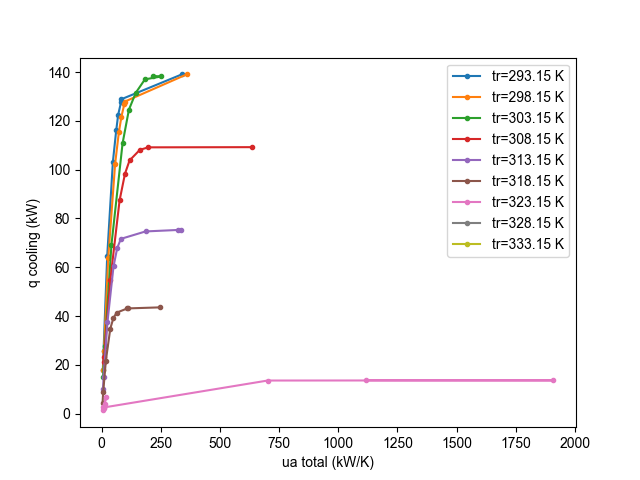

In [119]:
plt.figure()
plt.xlabel('ua total (kW/K)')
plt.ylabel('q cooling (kW)')
for t in t_heat_reject_range:
    plt.plot(opts2.UA_total[t], opts2.Q_evap[t], '.-', label="tr={} K".format(t))
plt.legend()
plt.show()

### Cooling vs Heat Reject Temperature, for each fraction of max

This doesn't have much meaning since the series are relative.

In [120]:
# Group by second index
opts3 = opts2.swaplevel()

<IPython.core.display.Javascript object>


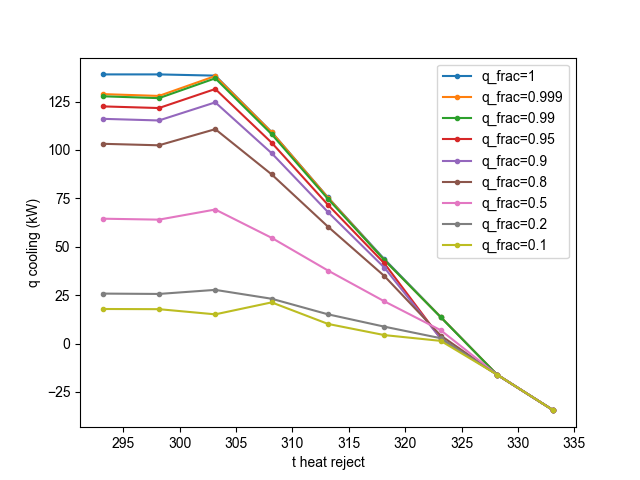

In [121]:
plt.figure()
plt.xlabel('t heat reject')
plt.ylabel('q cooling (kW)')
for q_frac in q_fraction_range:
    plt.plot(t_heat_reject_range, opts3.Q_evap[q_frac], '.-', label="q_frac={}".format(q_frac))
plt.legend()
plt.show()

### Spline things up a bit

<IPython.core.display.Javascript object>


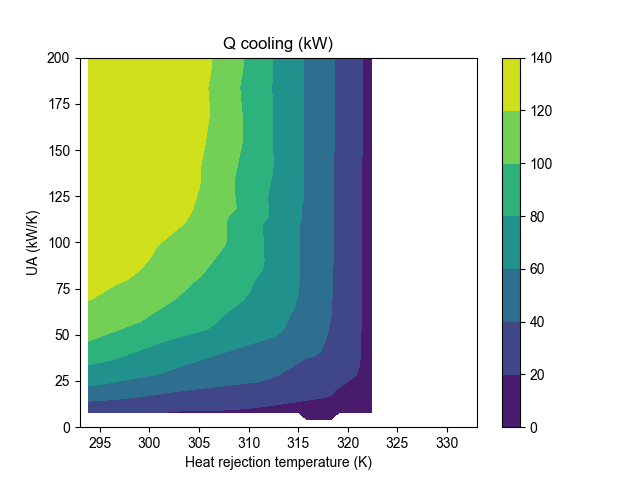

In [155]:
import scipy.interpolate
x,y,z = (array([tr for (tr,q_frac) in opts2.index]),
         array(opts2.UA_total),
         array(opts2.Q_evap))
X,Y=numpy.meshgrid(numpy.linspace(293,333),numpy.linspace(0,200))
mask = numpy.logical_not(numpy.isnan(y))
x = x[mask]
y = y[mask]
z = z[mask]
#q_of_t_ua = scipy.interpolate.SmoothBivariateSpline(x,y,z)
#q_of_t_ua = scipy.interpolate.interp2d(x,y,z)
#q_of_t_ua = scipy.interpolate.LSQBivariateSpline(x,y,z,[1,1,1,1,1],[1,1,1,1,1])
#Z=q_of_t_ua(X,Y)
#spline = scipy.interpolate.bisplrep(x,y,z)
Z = scipy.interpolate.griddata(numpy.array([x,y]).T,z,(X,Y))
Z2 = Z.copy()
Z2[numpy.isnan(Z)] = 0

plt.figure()
plt.xlabel('Heat rejection temperature (K)')
plt.ylabel('UA (kW/K)')
plt.title('Q cooling (kW)')
plt.contourf(X,Y,Z)
plt.colorbar()
plt.show()

### 3D plot of (T,UA,Q) with full extent of data

<IPython.core.display.Javascript object>


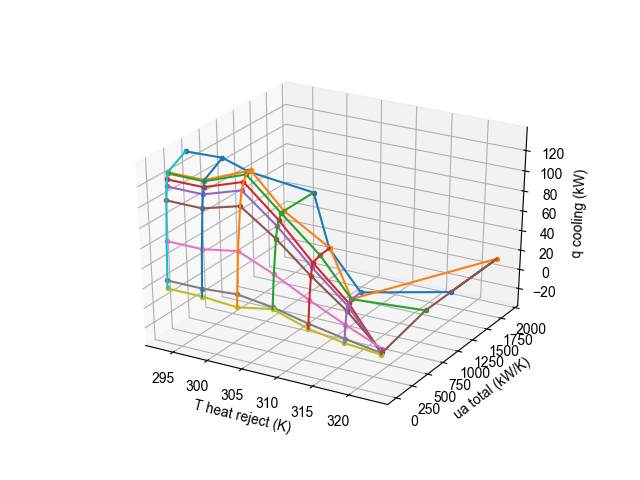

In [122]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('T heat reject (K)')
ax.set_ylabel('ua total (kW/K)')
ax.set_zlabel('q cooling (kW)')
for q_frac in q_fraction_range:
    ax.plot(t_heat_reject_range,
            array(opts3.UA_total[q_frac]),
            array(opts3.Q_evap[q_frac]),
            '.-')
for t in t_heat_reject_range:
    x = t * numpy.ones_like(q_fraction_range)
    ax.plot(x,
            array(opts2.UA_total[t]),
            array(opts2.Q_evap[t]))
#plt.ylim(0,200)
plt.show()

### Cropped 3D wireframe plot

<IPython.core.display.Javascript object>


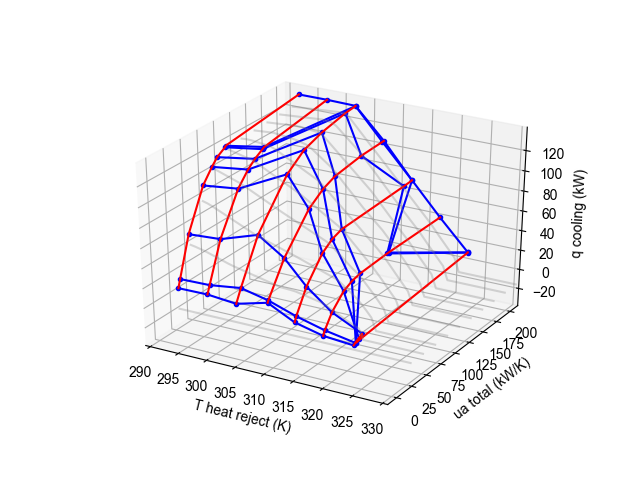

C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


In [188]:
# Zoom to relevant data, say, UA < 200
# 3d plot does not handle axis limits well, so instead
# we just need to mask off that data.

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('T heat reject (K)')
ax.set_ylabel('ua total (kW/K)')
ax.set_zlabel('q cooling (kW)')
#ax.plot(t_heat_reject_range,
#        array(opts3.Q_evap[1.0]),
#        zs=200,
#        zdir='y')
#for q_frac in q_fraction_range[1:]:
for q_frac in q_fraction_range:
    x,y,z = (t_heat_reject_range.copy(),
            array(opts3.UA_total[q_frac]),
            array(opts3.Q_evap[q_frac]))
    mask = y > 200.
    #x[mask] = nan
    y[mask] = 200
    #z[mask] = nan
    ax.plot(x,y,z,'b.-')
#ax.plot(array(opts2.UA_total[293.15])[1:],
#        array(opts2.Q_evap[293.15])[1:],
#        zs=293,
#        zdir='x')
for t in t_heat_reject_range:
    x,y,z = (t * numpy.ones_like(q_fraction_range),
            array(opts2.UA_total[t]),
            array(opts2.Q_evap[t]))
    mask = y > 200.
    #x[mask] = nan
    y[mask] = 200
    #z[mask] = nan
    ax.plot(x,y,z,'r')
ax.set_xlim(290,330)

for i in range(0,X.shape[0],5):
    ax.plot(X[i,1:],Y[i,1:],Z2[i,1:],'gray',alpha=0.3)
#ax.contour(X,Y,Z)

plt.show()

<IPython.core.display.Javascript object>


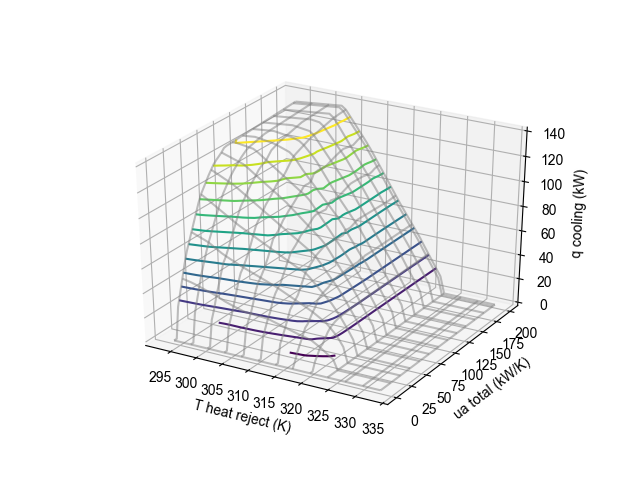

In [186]:
# If you got the griddata above ...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('T heat reject (K)')
ax.set_ylabel('ua total (kW/K)')
ax.set_zlabel('q cooling (kW)')

#for i in range(X.shape[0]):
#    ax.plot(X[i,:],Y[i,:],Z[i,:],'g',alpha=0.3)
#for j in range(X.shape[1]):
#    ax.plot(X[:,j],Y[:,j],Z[:,j],'y',alpha=0.3)

ax.plot_wireframe(X[:,1:],Y[:,1:],Z2[:,1:],color='gray',rstride=4,cstride=4,alpha=0.5)
#ax.plot_surface(X,Y,Z2,cmap=matplotlib.cm.Blues)
ax.contour(X,Y,Z,15)
ax.set_zlim(0,140)

plt.show()

### Bubble/color plot

<IPython.core.display.Javascript object>


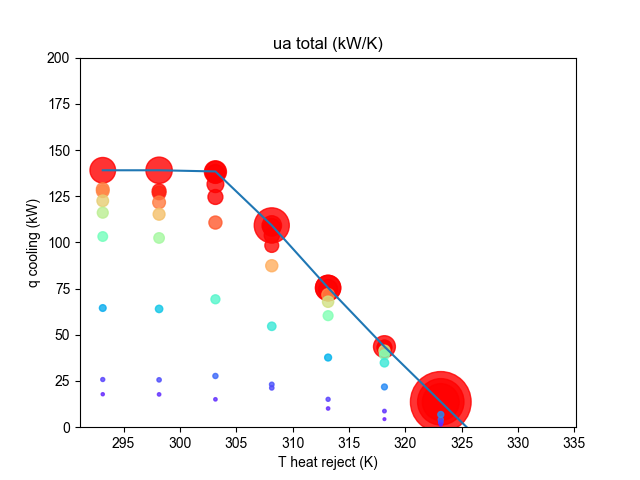

In [125]:
# Zoom to relevant data, say, set any UA over threshold to threshold (200)

fig = plt.figure()
plt.xlabel('T heat reject (K)')
plt.ylabel('q cooling (kW)')
plt.title('ua total (kW/K)')
x,y,z = ([tr for (tr,q_frac) in opts2.index],
         array(opts2.Q_evap),
         array(opts2.UA_total))
plt.scatter(x,y,c=z,vmin=0,vmax=100,cmap='rainbow',s=z,alpha=0.8)
plt.plot(t_heat_reject_range, opts3.Q_evap[1.0])
plt.ylim(0,200)
plt.show()

import scipy.interpolate

<IPython.core.display.Javascript object>


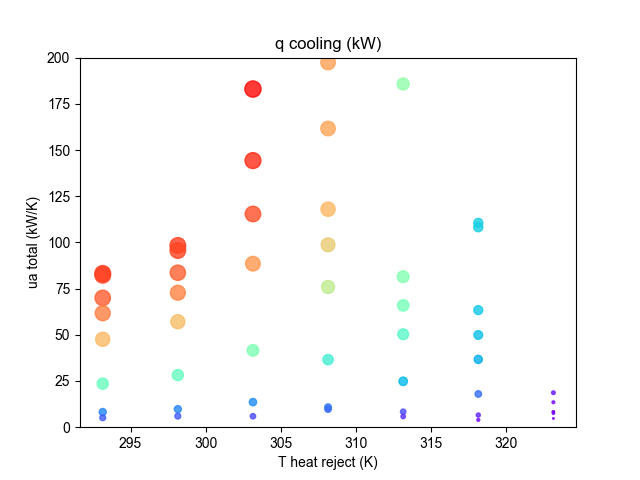

In [126]:
# Zoom to relevant data, say, set any UA over threshold to threshold (200)
matplotlib.cm
fig = plt.figure()
plt.xlabel('T heat reject (K)')
plt.ylabel('ua total (kW/K)')
plt.title('q cooling (kW)')
x,y,z = ([tr for (tr,q_frac) in opts2.index],
         array(opts2.UA_total),
         array(opts2.Q_evap))
plt.scatter(x,y,c=z,cmap='rainbow',s=z,alpha=0.8)
plt.ylim(0,200)
plt.show()

In [1]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').filter(":has(a)").map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>